In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Feature Engineering 함수

In [4]:
def label_encoding(raw_train, raw_test):
    train = raw_train.copy()
    test = raw_test.copy()
    workclass_mapping = {
        "Never-worked": 0,
        "Without-pay": 0,
        "no-working": 0,
        "Private": 0.25,
        "Self-emp-not-inc": 0.25,
        "Local-gov": 0.35,
        "State-gov": 0.35,
        "Federal-gov": 0.35,
        "Self-emp-inc": 0.55
    }
    marital_mapping = {
        'Married-AF-spouse': 0.45,
        'Married-civ-spouse': 0.45,
        'Divorced': 0.1,
        'Married-spouse-absent': 0.1,
        'Never-married': 0.1,
        'Separated': 0.1,
        'Widowed': 0.1
    }
    occupation_label_mapping = {
        'Exec-managerial': 0.45,
        'Prof-specialty': 0.45,
        'Protective-serv': 0.35,
        'Tech-support': 0.35,
        'Sales': 0.35,
        'Craft-repair': 0.25,
        'Transport-moving': 0.25,
        'Adm-clerical': 0.1,
        'Farming-fishing': 0.1,
        'Handlers-cleaners': 0.1,
        'Machine-op-inspct': 0.1,
        'Other-service': 0.1,
        'Priv-house-serv': 0.1,
        'baeksu': 0.1,
        'Armed-Forces': 0.1
    }
    race_label_mapping = {
        'Asian-Pac-Islander': 0.35,
        'White': 0.35,
        'Amer-Indian-Eskimo': 0.1,
        'Black': 0.1,
        'Other': 0.1
    }
    country_income_ratio = {
        'Cambodia': 35.71, 'Canada': 26.60, 'China': 24.49, 'Columbia': 0.00,
        'Cuba': 27.03, 'Dominican-Republic': 3.57, 'Ecuador': 14.29, 'El-Salvador': 11.11,
        'England': 34.85, 'France': 38.10, 'Germany': 28.85, 'Greece': 20.00,
        'Guatemala': 5.77, 'Haiti': 7.89, 'Holand-Netherlands': 0.00, 'Honduras': 0.00,
        'Hong': 25.00, 'Hungary': 14.29, 'India': 36.00, 'Iran': 34.38,
        'Ireland': 18.75, 'Italy': 32.20, 'Jamaica': 8.96, 'Japan': 39.22,
        'Laos': 10.00, 'Mexico': 4.90, 'Nicaragua': 3.70, 'Outlying-US(Guam-USVI-etc)': 0.00,
        'Peru': 0.00, 'Philippines': 29.30, 'Poland': 13.33, 'Portugal': 7.14,
        'Puerto-Rico': 11.63, 'Scotland': 22.22, 'South': 18.03, 'Taiwan': 38.10,
        'Thailand': 18.75, 'Trinadad&Tobago': 6.25, 'United-States': 23.72,
        'Vietnam': 10.20, 'Yugoslavia': 33.33
    }
    sex_label_mapping = {
        1: 0.3,
        0: 0.1
    }
    mapping = {
        'workclass': workclass_mapping,
        'marital.status': marital_mapping,
        'occupation': occupation_label_mapping,
        'race': race_label_mapping,
        'native.country': country_income_ratio,
        'sex': sex_label_mapping,
    }

    for key in mapping:
        train[key] = train[key].map(mapping[key])
        test[key] = test[key].map(mapping[key])

    train['native.country'] = train['native.country'].map(lambda x: country_income_ratio.get(x, 0) / 100)
    test['native.country'] = test['native.country'].map(lambda x: country_income_ratio.get(x, 0) / 100)
    return train, test

def split_data_label(raw_train, raw_test):
    X_train=raw_train.drop(['income'], axis=1)
    y_train=raw_train['income']
    X_test = raw_test.drop(['income'], axis = 1)
    y_test = raw_test['income']
    return X_train, y_train, X_test, y_test

def drop_columns(raw_train, raw_test, columns):
    train = raw_train.copy()
    test = raw_test.copy()
    train = train.drop(columns=columns)
    test = test.drop(columns=columns)
    return train, test

def onehot_encoding(raw_train, raw_test, column_list):
    train = pd.get_dummies(raw_train, dtype = int, columns = column_list)
    test = pd.get_dummies(raw_test, dtype = int, columns = column_list).reindex(columns = train.columns, fill_value = 0)
    return train, test

In [5]:
def scaling(raw_train, raw_test):
    train = raw_train.copy()
    test = raw_test.copy()
    # 'train'이 데이터프레임이고 스케일링할 열이 지정된 경우
    columns_to_scale = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

    # Min-Max 스케일링
    scaler = MinMaxScaler()

    train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
    test[columns_to_scale] = scaler.fit_transform(test[columns_to_scale])

    train = train.dropna()
    test = test.dropna()
    return train, test

### 모델 변수

In [6]:
def run_xgb(X_train, y_train, X_test, y_test):
    xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
    }

    #xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)
    xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='accuracy')
    xgb_grid_search.fit(X_train, y_train)

    print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
    print(f"Best accuracy for XGBoost: {xgb_grid_search.best_score_}")

    xgb_probs = xgb_grid_search.predict_proba(X_test)

    final_predictions = np.argmax(xgb_probs, axis=1)

    accuracy = accuracy_score(y_test, final_predictions)
    print(f"Soft Voting Accuracy: {accuracy}")

    return xgb_grid_search.best_estimator_

In [7]:
def run_cat(X_train, y_train, X_test, y_test):
    cat_param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'iterations': [100, 200]
    }

    cat = CatBoostClassifier(verbose=False, random_state=42)
    cat_grid_search = GridSearchCV(estimator=cat, param_grid=cat_param_grid, cv=5, scoring='accuracy')
    cat_grid_search.fit(X_train,y_train)

    print(f"Best parameters for CatBoost: {cat_grid_search.best_params_}")
    print(f"Best accuracy for CatBoost: {cat_grid_search.best_score_}")

    cat_probs = cat_grid_search.predict_proba(X_test)
    final_predictions = np.argmax(cat_probs, axis=1)

    accuracy = accuracy_score(y_test, final_predictions)
    print(f"Soft Voting Accuracy: {accuracy}")

    return cat_grid_search.best_estimator_

### Feature Importance & Feature Selection 함수

In [8]:
from xgboost import plot_importance

def check_feature_importance(casenum):

    df_imp = pd.DataFrame({'imp': casenum.feature_importances_}, index=casenum.get_booster().feature_names)

    print("Total number of features (before filtering):", len(df_imp))

    df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

    feat_num = df_imp.shape[0]
    print("Total number of features (after filtering):", feat_num)

    fig, ax = plt.subplots(figsize=(10, 12))
    plot_importance(casenum, ax=ax)

    return df_imp

In [9]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy_feature_selection(X_train, y_train, X_test, y_test, model_type="xgb", initial_model=None):
    # 모델 타입에 따라 초기 모델 설정
    if model_type == "xgb":
        if initial_model is not None:
            params = initial_model.get_params()  # 원래 모델에서 파라미터 가져오기
        else:
            params = {}  # 기본 파라미터 사용
        model = XGBClassifier(**params)

    elif model_type == "cat":
        if initial_model is not None:
            params = initial_model.get_params()  # 원래 모델에서 파라미터 가져오기
            params.pop('verbose', None)  # verbose는 params에서 제거
            model = CatBoostClassifier(**params, verbose=0)
        else:
            model = CatBoostClassifier(verbose=0)
            params = {}
    else:
        raise ValueError("Unsupported model type. Use 'xgb' or 'cat'.")

    # 전체 feature 사용하여 Accuracy 계산
    model.fit(X_train, y_train)
    accuracy_initial = accuracy_score(y_test, model.predict(X_test))
    accuracy_list = [accuracy_initial]
    remaining_features = [X_train.shape[1]]  # Initialize with total feature count

    print(f"Initial Accuracy with all features: {accuracy_initial}, Features remaining: {X_train.shape[1]}")

    # Feature Importance 추출
    if model_type == "xgb":
        feature_importances = model.feature_importances_
    elif model_type == "cat":
        feature_importances = model.get_feature_importance()

    feature_names = X_train.columns
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    importance_df = importance_df.sort_values(by='importance', ascending=True)  # 중요도가 낮은 순서로 정렬

    # 가장 중요도가 낮은 feature부터 하나씩 제거하며 Accuracy 계산
    for i in range(1, len(importance_df) + 1):
        # 중요도가 가장 낮은 feature들을 제거
        removed_feat = importance_df['feature'].iloc[:i].tolist()
        X_train_reduced = X_train.drop(columns=removed_feat)
        X_test_reduced = X_test.drop(columns=removed_feat)

        # 남아 있는 feature 개수
        num_features_left = X_train_reduced.shape[1]

        # 최소 1개의 feature가 남았는지 확인
        if num_features_left < 1:
            print(f"Stopping: Only {num_features_left} feature(s) left.")

            break

        remaining_features.append(num_features_left)  # Append remaining feature count

        # 모델 재학습
        model_reduced = XGBClassifier(**params) if model_type == "xgb" else CatBoostClassifier(**params, verbose=0)
        model_reduced.fit(X_train_reduced, y_train)

        # Accuracy 계산
        accuracy_reduced = accuracy_score(y_test, model_reduced.predict(X_test_reduced))
        accuracy_list.append(accuracy_reduced)

        print(f"Accuracy after removing {i} features: {accuracy_reduced}, Features remaining: {num_features_left}")

    return accuracy_list, remaining_features

In [10]:
def plot_accuracy_change(accuracy_list, remaining_features, model_name):

    max_accuracy = max(accuracy_list)
    max_features = remaining_features[accuracy_list.index(max_accuracy)]

    print(f"Maximum Accuracy: {max_accuracy:.4f}, Number of Features: {max_features}")


    plt.figure(figsize=(10, 6))
    plt.plot(remaining_features, accuracy_list, marker='o', label=model_name)
    plt.gca().invert_xaxis()
    plt.xticks(remaining_features)
    plt.title(f'Accuracy Score Change with Feature Removal ({model_name})')
    plt.xlabel('Remaining Features')
    plt.ylabel('Accuracy Score')
    plt.grid()
    plt.legend()
    plt.show()

In [11]:
def plot_top_n_feature_importance(casenum, n):
    # Get feature importance
    df_imp = pd.DataFrame({'imp': casenum.feature_importances_},
                          index=casenum.get_booster().feature_names)

    # Filter features with importance greater than 0
    df_imp = df_imp[df_imp.imp > 0].sort_values('imp', ascending=False)  # Sort by importance
    top_n_features = df_imp.head(n)  # Get top n features

    # Plot top n feature importance
    plt.figure(figsize=(12, 8))  # Increased figure size
    bars = plt.barh(top_n_features.index, top_n_features['imp'], color='lightblue')
    plt.xlabel('Importance', fontsize=14)
    plt.title(f'Top {n} Features by Importance', fontsize=16)
    plt.grid(axis='x')

    # Annotate the bars with the importance values
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.4f}',
                 va='center', ha='left', color='black', fontsize=10)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

### 데이터 불러오기

In [12]:
# read raw data
raw_train = pd.read_csv("/content/drive/My Drive/guide_train.csv")
raw_test = pd.read_csv("/content/drive/My Drive/guide_test.csv")

# sex에 대해 Male이면 1, Female이면 0으로 인코딩
encoded_train = raw_train.copy()
encoded_test = raw_test.copy()
encoded_train['sex'] = encoded_train['sex'].replace({'Male': 1, 'Female': 0})
encoded_test['sex'] = encoded_test['sex'].replace({'Male': 1, 'Female': 0})

<ipython-input-12-e2a97c89bdf7>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_train['sex'] = encoded_train['sex'].replace({'Male': 1, 'Female': 0})
<ipython-input-12-e2a97c89bdf7>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_test['sex'] = encoded_test['sex'].replace({'Male': 1, 'Female': 0})


### null 제거 후 onehot encoding 성능 (case 1)

In [13]:
case1_train = pd.get_dummies(encoded_train.dropna(), dtype = int)
case1_test = pd.get_dummies(encoded_test.dropna(), dtype = int).reindex(columns = case1_train.columns, fill_value = 0)
case1_xgb = run_xgb(*split_data_label(case1_train, case1_test))

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8702532643580462
Soft Voting Accuracy: 0.8713698448481634


Total number of features (before filtering): 103
Total number of features (after filtering): 75


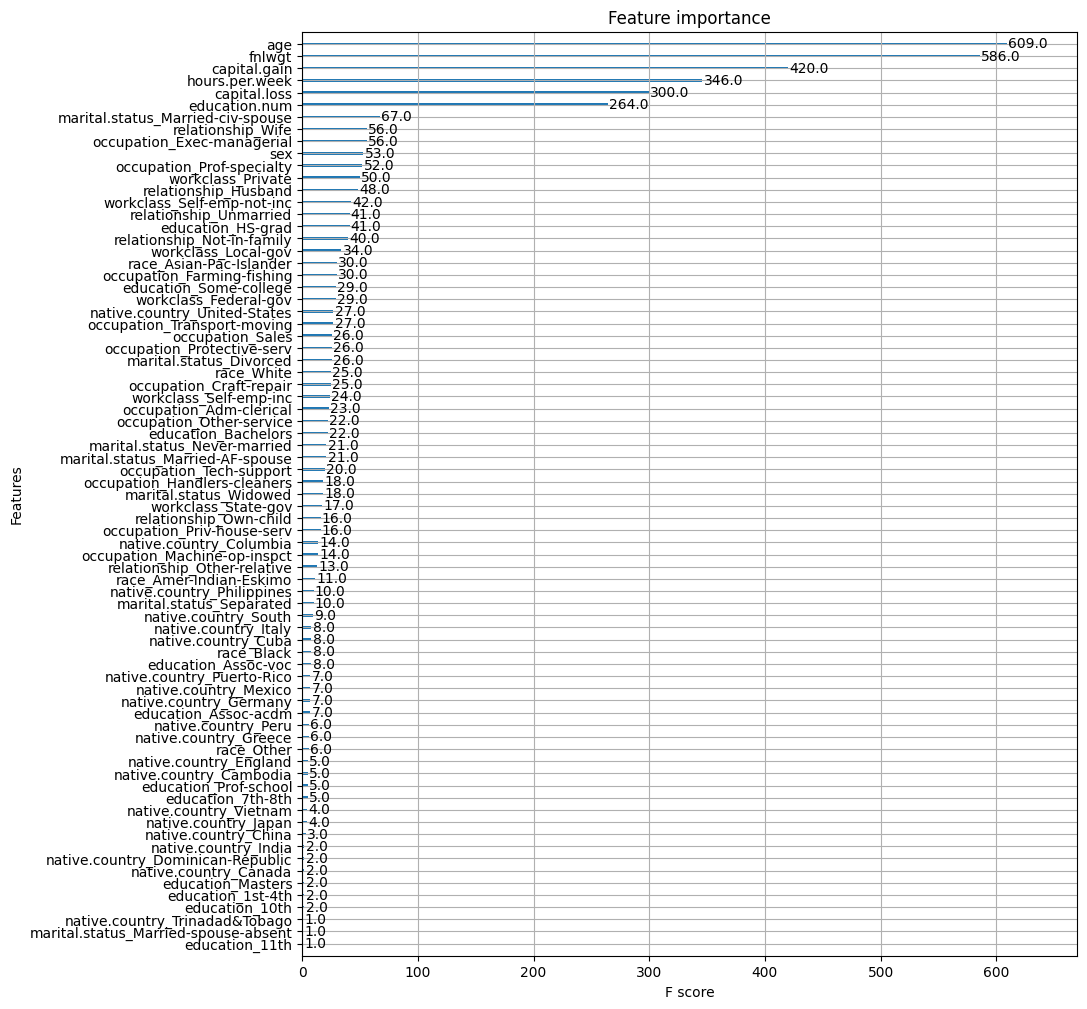

In [14]:
feature_1 = check_feature_importance(case1_xgb)

In [15]:
feature_case1_xgb, features = evaluate_accuracy_feature_selection(*split_data_label(case1_train, case1_test), "xgb", case1_xgb)

Initial Accuracy with all features: 0.8713698448481634, Features remaining: 103
Accuracy after removing 1 features: 0.8713698448481634, Features remaining: 102
Accuracy after removing 2 features: 0.8713698448481634, Features remaining: 101
Accuracy after removing 3 features: 0.8713698448481634, Features remaining: 100
Accuracy after removing 4 features: 0.8713698448481634, Features remaining: 99
Accuracy after removing 5 features: 0.8713698448481634, Features remaining: 98
Accuracy after removing 6 features: 0.8713698448481634, Features remaining: 97
Accuracy after removing 7 features: 0.8713698448481634, Features remaining: 96
Accuracy after removing 8 features: 0.8713698448481634, Features remaining: 95
Accuracy after removing 9 features: 0.8713698448481634, Features remaining: 94
Accuracy after removing 10 features: 0.8713698448481634, Features remaining: 93
Accuracy after removing 11 features: 0.8713698448481634, Features remaining: 92
Accuracy after removing 12 features: 0.8713698

Maximum Accuracy: 0.8714, Number of Features: 103


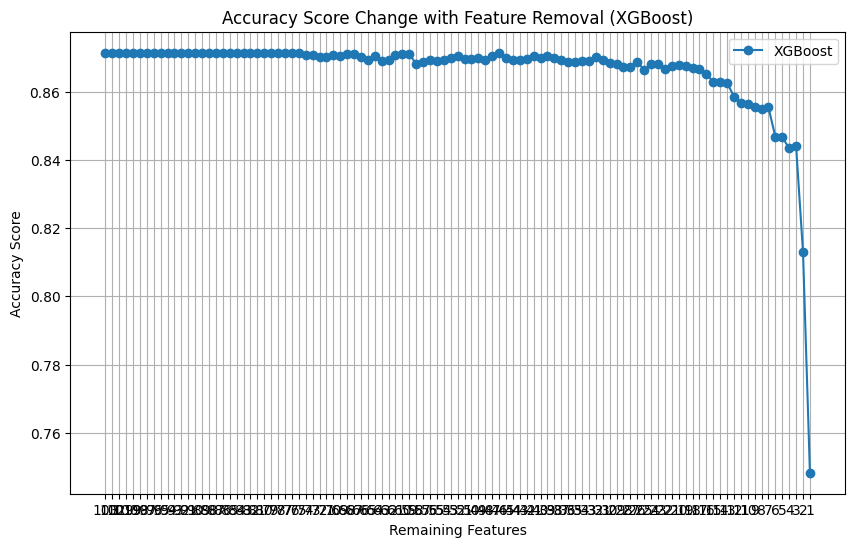

In [16]:
plot_accuracy_change(feature_case1_cat, features, 'XGBoost')

In [17]:
case1_train = pd.get_dummies(encoded_train.dropna(), dtype = int)
case1_test = pd.get_dummies(encoded_test.dropna(), dtype = int).reindex(columns = case1_train.columns, fill_value = 0)
case1_cat = run_cat(*split_data_label(case1_train, case1_test))

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.2}
Best accuracy for CatBoost: 0.8684850545403032
Soft Voting Accuracy: 0.8692481103301949


### null 포함 onehot encoding 성능 (case2)

In [ ]:
case2_train = pd.get_dummies(encoded_train, dummy_na = True, dtype = int)
case2_test = pd.get_dummies(encoded_test, dummy_na = True, dtype = int).reindex(columns = case2_train.columns, fill_value = 0)
case2_xgb = run_xgb(*split_data_label(case2_train, case2_test))

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8623521470645622
Soft Voting Accuracy: 0.8674260591526779


Total number of features (before filtering): 108
Total number of features (after filtering): 63


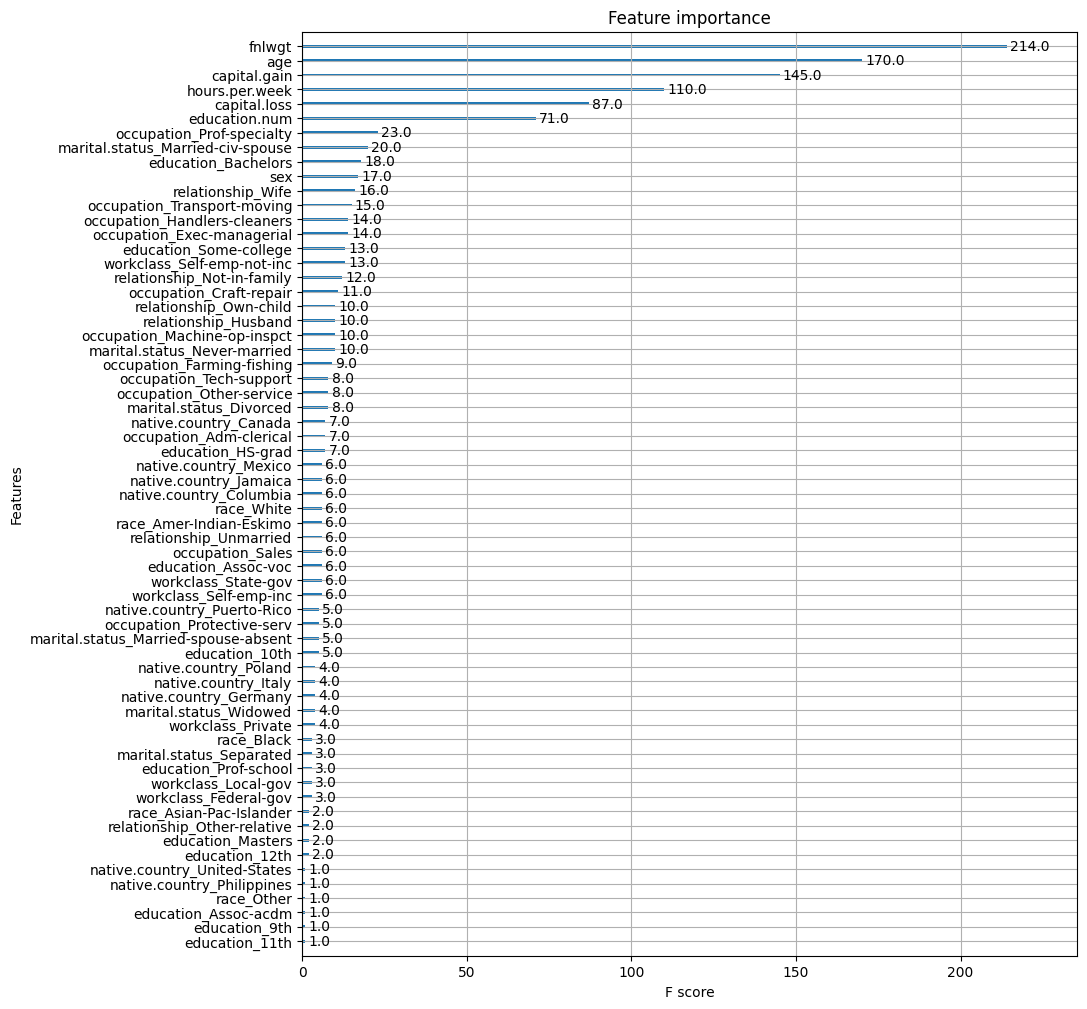

In [ ]:
feature_2 = check_feature_importance(case2_xgb)

In [ ]:
feature_2_zero = check_zero_feature_importance(case2_xgb)

Total number of features (before filtering): 108
Number of features with zero importance: 45
Features with zero importance:
 ['workclass_Without-pay', 'workclass_nan', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_Doctorate', 'education_Preschool', 'education_nan', 'marital.status_Married-AF-spouse', 'marital.status_nan', 'occupation_Armed-Forces', 'occupation_Priv-house-serv', 'occupation_nan', 'relationship_nan', 'race_nan', 'native.country_Cambodia', 'native.country_China', 'native.country_Cuba', 'native.country_Dominican-Republic', 'native.country_Ecuador', 'native.country_El-Salvador', 'native.country_England', 'native.country_France', 'native.country_Greece', 'native.country_Guatemala', 'native.country_Haiti', 'native.country_Honduras', 'native.country_Hong', 'native.country_Hungary', 'native.country_India', 'native.country_Iran', 'native.country_Ireland', 'native.country_Japan', 'native.country_Laos', 'native.country_Nicaragua', 'native.country_Peru',

In [ ]:
feature_case2_xgb, features = evaluate_accuracy_feature_selection(*split_data_label(case2_train, case2_test), "xgb", case2_xgb)

Initial Accuracy with all features: 0.8674260591526779, Features remaining: 108
Accuracy after removing 1 features: 0.8674260591526779, Features remaining: 107
Accuracy after removing 2 features: 0.8674260591526779, Features remaining: 106
Accuracy after removing 3 features: 0.8674260591526779, Features remaining: 105
Accuracy after removing 4 features: 0.8674260591526779, Features remaining: 104
Accuracy after removing 5 features: 0.8674260591526779, Features remaining: 103
Accuracy after removing 6 features: 0.8674260591526779, Features remaining: 102
Accuracy after removing 7 features: 0.8674260591526779, Features remaining: 101
Accuracy after removing 8 features: 0.8674260591526779, Features remaining: 100
Accuracy after removing 9 features: 0.8674260591526779, Features remaining: 99
Accuracy after removing 10 features: 0.8674260591526779, Features remaining: 98
Accuracy after removing 11 features: 0.8674260591526779, Features remaining: 97
Accuracy after removing 12 features: 0.86

Maximum Accuracy: 0.8678, Number of Features: 54


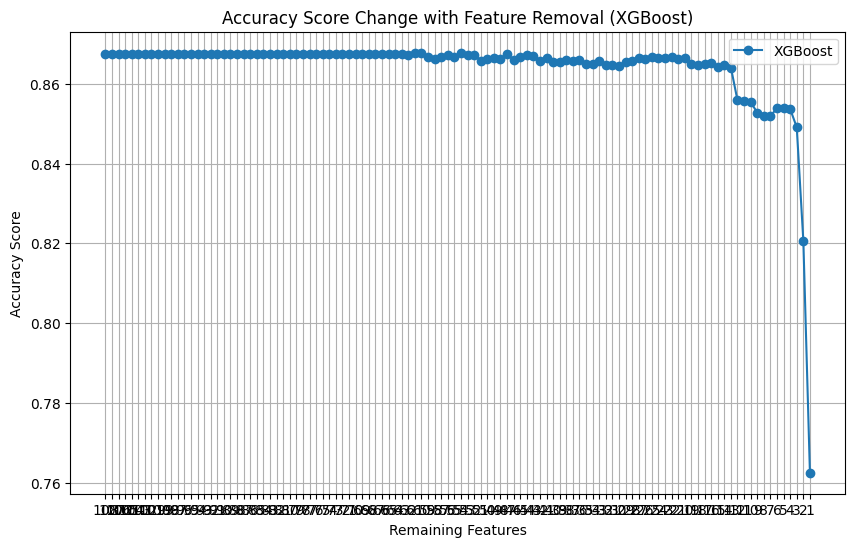

In [ ]:
plot_accuracy_change(feature_case2_xgb, features, 'XGBoost')

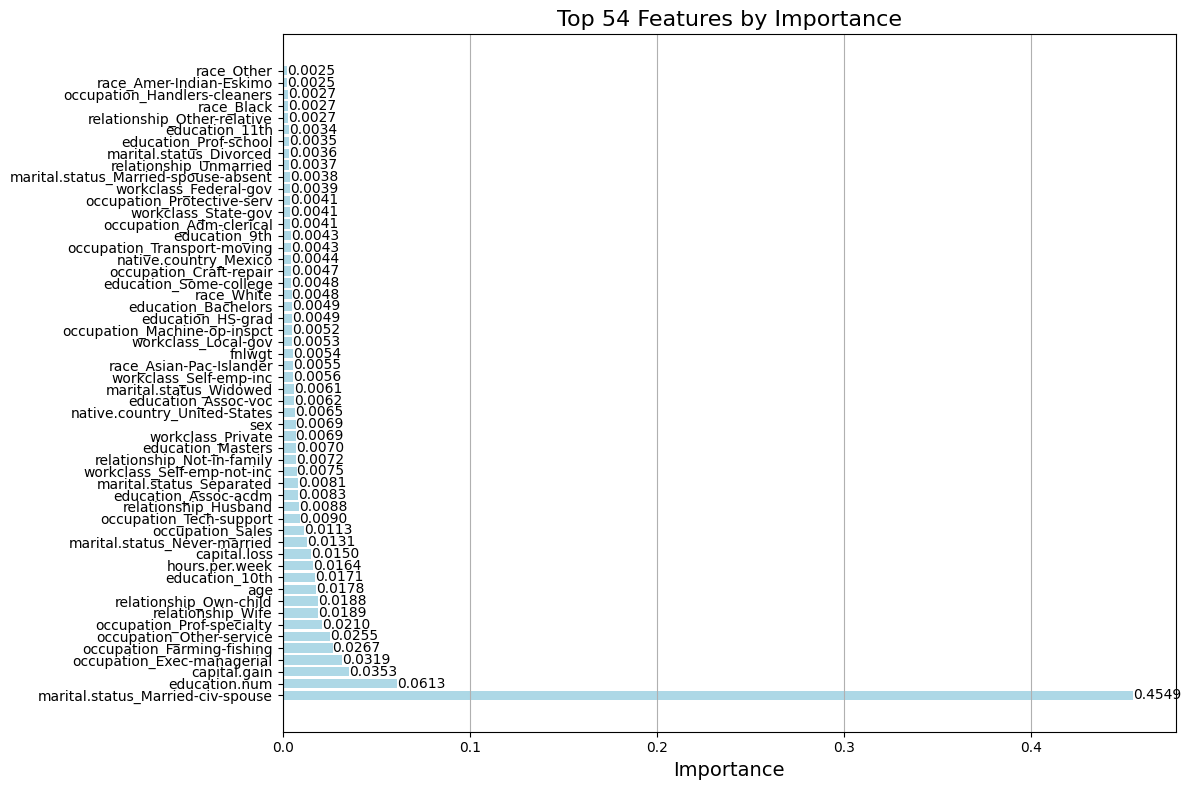

In [ ]:
top_n_features = plot_top_n_feature_importance(case2_xgb, 54)

In [ ]:
case2_train = pd.get_dummies(encoded_train, dummy_na = True, dtype = int)
case2_test = pd.get_dummies(encoded_test, dummy_na = True, dtype = int).reindex(columns = case2_train.columns, fill_value = 0)
run_cat(*split_data_label(case2_train, case2_test))

Best parameters for CatBoost: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best accuracy for CatBoost: 0.8743005595523581
Soft Voting Accuracy: 0.8665959421827344


### 결론: onehot encoding with dropna가 더 좋다

In [ ]:
train_imputed = encoded_train.copy()
test_imputed = encoded_test.copy()

train_workclass_null = raw_train['workclass'].isna()
train_occupation_null = raw_train['occupation'].isna()

train_capital_gain_under_5000 = raw_train['capital.gain']<50000
train_income_is_1 = raw_train['income'] == 1

train_imputed.loc[ train_workclass_null & train_occupation_null, 'workclass' ] \
= train_imputed.loc[ train_workclass_null & train_occupation_null, 'workclass' ].replace(np.nan, 'no-working')

train_imputed.loc[ train_workclass_null & train_occupation_null, 'occupation' ] \
= train_imputed.loc[ train_workclass_null & train_occupation_null, 'occupation' ].replace(np.nan, 'baeksu')

train_imputed.drop(
    raw_train[
        train_workclass_null \
        & train_occupation_null \
        & train_capital_gain_under_5000 \
        &train_income_is_1
    ].index , axis=0,inplace=True)

# 전부 다 null 인데, capital.gain은 50000 미만 즉, 진짜 돈없는 백수 근데 income은 1인 애들 즉 예외 case 는 제거
# (혹시나 경향성이 있나 찾아보고 싶었지만 아예 이런 case가 존재하지 않았음)
# workclass, occupation 전부 null 즉, income 0인 경향이 높지만, capital_gain은 낮은 경우 즉, 경향성에 위배되는 case 제거.


test_workclass_null= raw_test['workclass'].isna()
test_occupation_null= raw_test['occupation'].isna()

test_capital_gain_under_5000 = raw_test['capital.gain']<50000

test_imputed.loc[ test_workclass_null & test_occupation_null, 'workclass' ] \
= test_imputed.loc[ test_workclass_null & test_occupation_null, 'workclass' ].replace(np.nan,'no-working')

test_imputed.loc[ test_workclass_null & test_occupation_null, 'occupation' ] \
=test_imputed.loc[ test_workclass_null & test_occupation_null, 'occupation' ].replace(np.nan,'baeksu')

test_imputed.drop(test_workclass_null[ test_workclass_null & test_occupation_null & test_capital_gain_under_5000].index , axis=0,inplace=True)
# test data 또한 이러한 case가 존재하지 않았음

# native.country가 null이고 race가 White인 경우 native.country를 United-States로 변경
train_imputed_country = train_imputed.copy()
test_imputed_country = test_imputed.copy()
train_imputed_country.loc[train_imputed_country['native.country'].isnull() & (train_imputed_country['race'] == 'White'), 'native.country'] = 'United-States'
test_imputed_country.loc[test_imputed_country['native.country'].isnull() & (test_imputed_country['race'] == 'White'), 'native.country'] = 'United-States'

train_imputed_country2 = train_imputed.copy()
test_imputed_country2 = test_imputed.copy()
train_imputed_country2.loc[train_imputed_country2['native.country'].isnull() & (train_imputed_country2['race'] == 'White'), 'native.country'] = 'white-country'
test_imputed_country2.loc[test_imputed_country2['native.country'].isnull() & (test_imputed_country2['race'] == 'White'), 'native.country'] = 'white-country'



### case3 baeksu, no-working (with onehot encoding dropping na)

In [ ]:
case3_train = pd.get_dummies(train_imputed.dropna(), dtype = int)
case3_test = pd.get_dummies(test_imputed.dropna(), dtype = int).reindex(columns = case3_train.columns, fill_value = 0)
run_xgb(*split_data_label(case3_train, case3_test))

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8623521470645622
Soft Voting Accuracy: 0.862939226519337


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
case3_train = pd.get_dummies(train_imputed.dropna(), dtype = int)
case3_test = pd.get_dummies(test_imputed.dropna(), dtype = int).reindex(columns = case3_train.columns, fill_value = 0)
run_cat(*split_data_label(case3_train, case3_test))

Best parameters for CatBoost: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best accuracy for CatBoost: 0.8612924574568505
Soft Voting Accuracy: 0.8630718232044199


### case4 United-States (with onehot encoding dropping na)

In [ ]:
case4_train = encoded_train.copy()
case4_test = encoded_test.copy()
case4_train.loc[case4_train['native.country'].isnull() & (case4_train['race'] == 'White'), 'native.country'] = 'United-States'
case4_test.loc[case4_test['native.country'].isnull() & (case4_test['race'] == 'White'), 'native.country'] = 'United-States'
case4_train = pd.get_dummies(case4_train.dropna(), dtype = int)
case4_test = pd.get_dummies(case4_test.dropna(), dtype = int).reindex(columns = case4_train.columns, fill_value = 0)
run_xgb(*split_data_label(case4_train, case4_test))

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best accuracy for XGBoost: 0.8695464059574001
Soft Voting Accuracy: 0.8681872430712108


In [ ]:
case4_train = encoded_train.copy()
case4_test = encoded_test.copy()
case4_train.loc[case4_train['native.country'].isnull() & (case4_train['race'] == 'White'), 'native.country'] = 'United-States'
case4_test.loc[case4_test['native.country'].isnull() & (case4_test['race'] == 'White'), 'native.country'] = 'United-States'
case4_train = pd.get_dummies(case4_train.dropna(), dtype = int)
case4_test = pd.get_dummies(case4_test.dropna(), dtype = int).reindex(columns = case4_train.columns, fill_value = 0)
run_cat(*split_data_label(case4_train, case4_test))

Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.2}
Best accuracy for CatBoost: 0.870677285136788
Soft Voting Accuracy: 0.8683198514785837


### case5 baeksu + United-States (with onehot encoding droping na)

In [ ]:
case5_train = pd.get_dummies(train_imputed_country.dropna(), dtype = int)
case5_test = pd.get_dummies(test_imputed_country.dropna(), dtype = int).reindex(columns = case6_train.columns, fill_value = 0)
run_xgb(*split_data_label(case5_train, case5_test))

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best accuracy for XGBoost: 0.8764566239982345
Soft Voting Accuracy: 0.869778543959687


In [ ]:
case5_train = pd.get_dummies(train_imputed_country.dropna(), dtype = int)
case5_test = pd.get_dummies(test_imputed_country.dropna(), dtype = int).reindex(columns = case6_train.columns, fill_value = 0)
run_cat(*split_data_label(case5_train, case5_test))

Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.2}
Best accuracy for CatBoost: 0.8763754551737545
Soft Voting Accuracy: 0.8660655085532423


### case6 white-country (instead of United-States) (with onehot encoding droping na)

In [ ]:
case6_train = encoded_train.copy()
case6_test = encoded_test.copy()
case6_train.loc[case6_train['native.country'].isnull() & (case6_train['race'] == 'White'), 'native.country'] = 'white-country'
case6_test.loc[case6_test['native.country'].isnull() & (case6_test['race'] == 'White'), 'native.country'] = 'white-country'
case6_train = pd.get_dummies(case6_train.dropna(), dtype = int)
case6_test = pd.get_dummies(case6_test.dropna(), dtype = int).reindex(columns = case6_train.columns, fill_value = 0)
run_xgb(*split_data_label(case6_train, case6_test))

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best accuracy for XGBoost: 0.8691549314032461
Soft Voting Accuracy: 0.8687176767007029


In [ ]:
case6_train = encoded_train.copy()
case6_test = encoded_test.copy()
case6_train.loc[case6_train['native.country'].isnull() & (case6_train['race'] == 'White'), 'native.country'] = 'white-country'
case6_test.loc[case6_test['native.country'].isnull() & (case6_test['race'] == 'White'), 'native.country'] = 'white-country'
case6_train = pd.get_dummies(case6_train.dropna(), dtype = int)
case6_test = pd.get_dummies(case6_test.dropna(), dtype = int).reindex(columns = case6_train.columns, fill_value = 0)
run_cat(*split_data_label(case6_train, case6_test))

Best parameters for CatBoost: {'depth': 6, 'iterations': 100, 'learning_rate': 0.2}
Best accuracy for CatBoost: 0.8693724172666648
Soft Voting Accuracy: 0.8655350749237501


### case7 baeksu + white-country (instead of United-States) (with onehot encoding droping na)

In [ ]:
case7_train = pd.get_dummies(train_imputed_country2.dropna(), dtype = int)
case7_test = pd.get_dummies(test_imputed_country2.dropna(), dtype = int).reindex(columns = case7_train.columns, fill_value = 0)
run_xgb(*split_data_label(case7_train, case7_test))

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best accuracy for XGBoost: 0.8768219331513338
Soft Voting Accuracy: 0.8688502851080758


In [ ]:
case7_train = pd.get_dummies(train_imputed_country2.dropna(), dtype = int)
case7_test = pd.get_dummies(test_imputed_country2.dropna(), dtype = int).reindex(columns = case7_train.columns, fill_value = 0)
run_cat(*split_data_label(case7_train, case7_test))

Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.2}
Best accuracy for CatBoost: 0.8767001963955933
Soft Voting Accuracy: 0.8680546346638377


In [ ]:
# custom encoding applied
custom_encoded_train, custom_encoded_test = label_encoding(train_imputed, test_imputed)

# onehot encoding applied to all categorical columns
onehot_encoded_train, onehot_encoded_test = onehot_encoding(train_imputed, test_imputed, column_list = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country'])

# onehot encoding applied to all categorical columns after custom encoding applied (grouping & onehot encoding)
grouped_onehot_encoded_train, grouped_onehot_encoded_test = onehot_encoding(custom_encoded_train, custom_encoded_test, column_list = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country'])

In [ ]:
# custom encoding applied and drop 'education', 'relationship' and 'fnlwgt'
original_train, original_test = drop_columns(custom_encoded_train, custom_encoded_test, ['education', 'relationship', 'fnlwgt'])

# custom encoding applied and drop 'education', 'relationship' and 'fnlwgt' with scaling
scaled_train, scaled_test = scaling(original_train, original_test)

# custom encoding applied and onehot encoding applied for 'education' and 'relationship'
case8_train, case8_test = onehot_encoding(custom_encoded_train, custom_encoded_test, ['education', 'relationship'])

### case8 baeksu + custom encoding + onehot encoding for 'education' and 'relationship'

In [ ]:
run_xgb(*split_data_label(case8_train.dropna(), case8_test))

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy for XGBoost: 0.8742046926147145
Soft Voting Accuracy: 0.8677894178490916


In [ ]:
run_cat(*split_data_label(case8_train.dropna(), case8_test))

Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Best accuracy for CatBoost: 0.8737212521480406
Soft Voting Accuracy: 0.8656676833311232


### case9 baeksu + custom encoding

In [ ]:
case9_xgb = run_xgb(*split_data_label(original_train.dropna(), original_test))

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8626176627239218
Soft Voting Accuracy: 0.8610056925996205


total number of features = 10
                     imp
workclass       0.008945
race            0.009184
sex             0.024968
capital.loss    0.036888
hours.per.week  0.045289
age             0.049944
capital.gain    0.095317
education.num   0.099099
occupation      0.143567
marital.status  0.486799


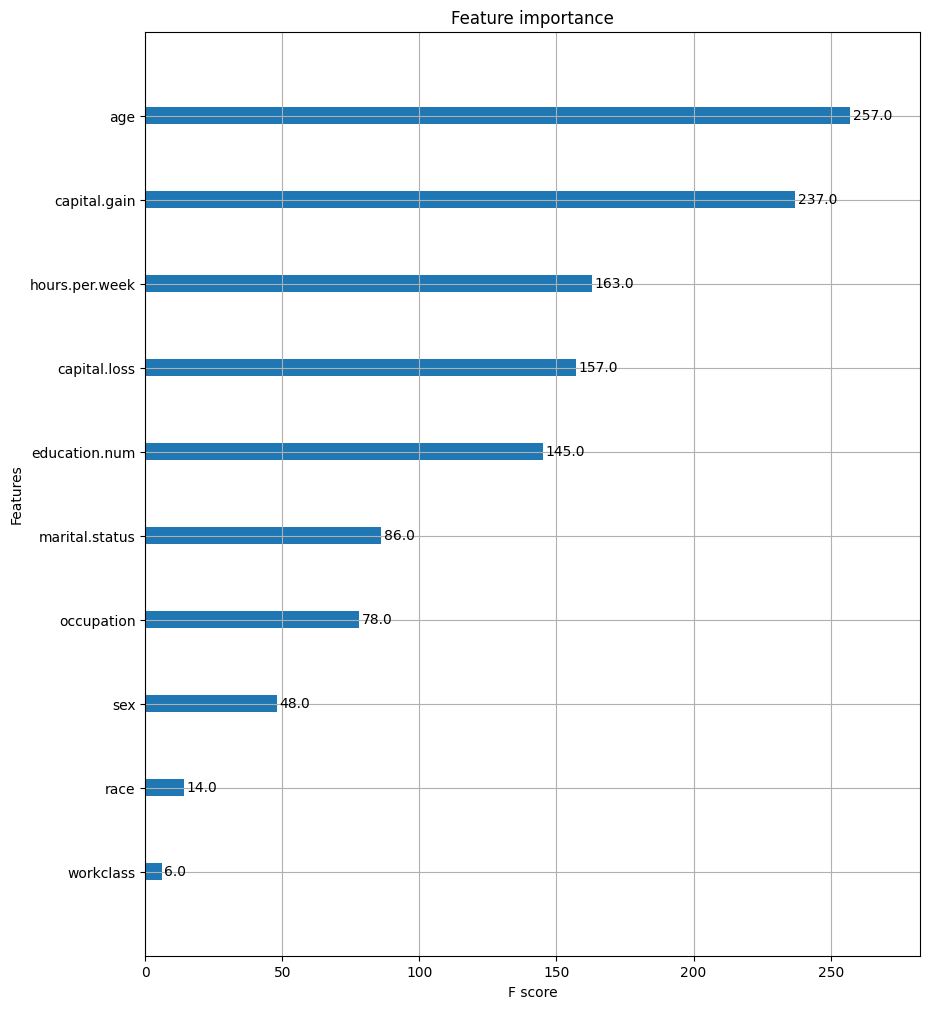

In [ ]:
check_feature_importance(case9_xgb)

In [ ]:
feature_case9_xgb, features_9 = evaluate_accuracy_feature_selection(*split_data_label(original_train.dropna(), original_test), "xgb", case9_xgb)

Initial Accuracy with all features: 0.8610056925996205, Features remaining: 11
Accuracy after removing 1 features: 0.8610056925996205, Features remaining: 10
Accuracy after removing 2 features: 0.8611350698637226, Features remaining: 9
Accuracy after removing 3 features: 0.8616094531654304, Features remaining: 8
Accuracy after removing 4 features: 0.8611350698637226, Features remaining: 7
Accuracy after removing 5 features: 0.8525530446782819, Features remaining: 6
Accuracy after removing 6 features: 0.8532861825081939, Features remaining: 5
Accuracy after removing 7 features: 0.8486286010005175, Features remaining: 4
Accuracy after removing 8 features: 0.8196480938416423, Features remaining: 3
Accuracy after removing 9 features: 0.8117992064861135, Features remaining: 2
Accuracy after removing 10 features: 0.7517681559427289, Features remaining: 1
Stopping: Only 0 feature(s) left.


Maximum Accuracy: 0.8616, Number of Features: 8


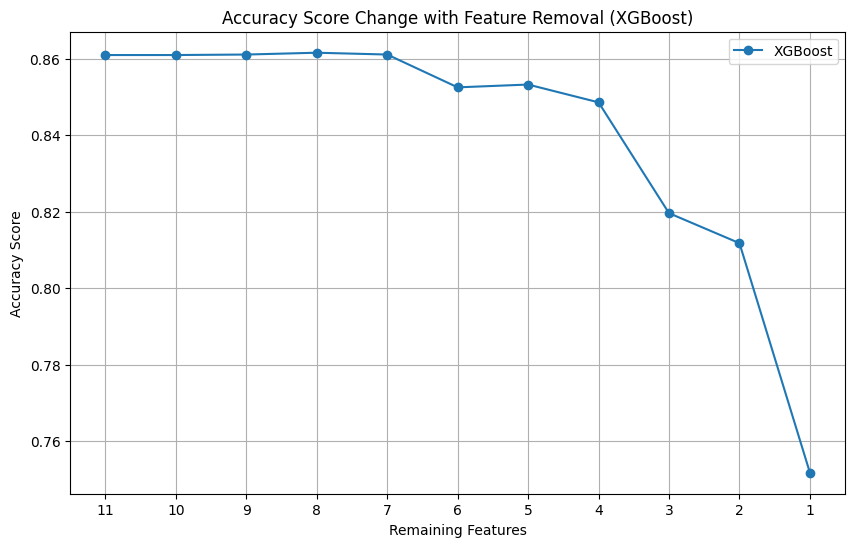

In [ ]:
plot_accuracy_change(feature_case9_xgb, features_9, 'XGBoost')

In [ ]:
case9_cat = run_cat(*split_data_label(original_train.dropna(), original_test))

Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Best accuracy for CatBoost: 0.8612918422269213
Soft Voting Accuracy: 0.8631619803346559


In [ ]:
feature_case9_cat = evaluate_accuracy_feature_selection(*split_data_label(original_train.dropna(), original_test), "cat", case9_cat)

Initial Accuracy with all features: 0.8631619803346559, Features remaining: 11
Accuracy after removing 1 features: 0.8631619803346559, Features remaining: 10
Accuracy after removing 2 features: 0.862860100051751, Features remaining: 9
Accuracy after removing 3 features: 0.8624719682594445, Features remaining: 8
Accuracy after removing 4 features: 0.8613075728825255, Features remaining: 7
Accuracy after removing 5 features: 0.8534586855269968, Features remaining: 6
Accuracy after removing 6 features: 0.8468604450577885, Features remaining: 5
Accuracy after removing 7 features: 0.812618595825427, Features remaining: 4
Accuracy after removing 8 features: 0.8032603070553734, Features remaining: 3
Accuracy after removing 9 features: 0.8033896843194755, Features remaining: 2
Accuracy after removing 10 features: 0.7517681559427289, Features remaining: 1
Stopping: Only 0 feature(s) left.


#### case10 baeksu + custom encoding + scaling + droping 'education', 'relationship', and 'fnlwgt'

In [ ]:
run_xgb(*split_data_label(scaled_train.dropna(), scaled_test))

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy for XGBoost: 0.8745269565168016
Soft Voting Accuracy: 0.8541307518896698


In [ ]:
run_cat(*split_data_label(scaled_train.dropna(), scaled_test))

Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Best accuracy for CatBoost: 0.8737615341218573
Soft Voting Accuracy: 0.850550324890598


### case11 baeksu + group encoding (one hot encoding with custom encoding)

In [ ]:
run_xgb(*split_data_label(grouped_onehot_encoded_train.dropna(), grouped_onehot_encoded_test))

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy for XGBoost: 0.8740389267514367
Soft Voting Accuracy: 0.8667285505901074


In [ ]:
run_cat(*split_data_label(grouped_onehot_encoded_train.dropna(), grouped_onehot_encoded_test))

Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.2}
Best accuracy for CatBoost: 0.8745222374234588
Soft Voting Accuracy: 0.8640763824426468


### case12 case3 + oversampling

In [ ]:
'''
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
case12_train = pd.get_dummies(train_imputed.dropna(), dtype = int)
case12_test = pd.get_dummies(test_imputed.dropna(), dtype = int).reindex(columns = case12_train.columns, fill_value = 0)
train_input_over, train_target_over = smote.fit_resample(case12_train.drop(['income'], axis = 1), case12_train['income'])
X_train, y_train, X_test, y_test = split_data_label(case12_train, case12_test)
run_xgb(train_input_over, train_target_over, X_test, y_test)
'''

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8824331976926032
Soft Voting Accuracy: 0.8526408839779005


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
'''
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
case12_train = pd.get_dummies(train_imputed.dropna(), dtype = int)
case12_test = pd.get_dummies(test_imputed.dropna(), dtype = int).reindex(columns = case12_train.columns, fill_value = 0)
train_input_over, train_target_over = smote.fit_resample(case12_train.drop(['income'], axis = 1), case12_train['income'])
X_train, y_train, X_test, y_test = split_data_label(case12_train, case12_test)
run_cat(train_input_over, train_target_over, X_test, y_test)
'''

Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.2}
Best accuracy for CatBoost: 0.8803955257003798
Soft Voting Accuracy: 0.8564419889502762


### 국가 이분할

**국가**

-국가를 미국과 미국이 아닌 국가로 분류
(native.country를 삭제하지는 않는것이 성능이 좋아서 삭제 안함)

-인종이 백인이고 income이 1인데 국가가 null값이면, 연과규칙탐색에 근거하여 미국으로 처리

--> 동시에 처리했을때 성능 올라감을 확인할 수 있음

In [19]:
def categorize_by_native_country_with_conditions(df):
    # Drop rows where 'native.country' is null and create an explicit copy
    df_cleaned = df.dropna(subset=['native.country']).copy()

    # Count the number of dropped rows
    dropped_count = len(df) - len(df_cleaned)

    # Categorize based on 'native.country' with additional conditions for 'White' and 'income'
    df_cleaned['country_category'] = df_cleaned.apply(
        lambda row: 'USA' if row['native.country'] == 'United-States' or
        (row['race'] == 'White' and row['income'] == 1) else 'Non-USA',
        axis=1
    )

    return df_cleaned, dropped_count

In [20]:
# Apply the corrected function to categorize by native country with additional conditions
encoded_train_cleaned, _ = categorize_by_native_country_with_conditions(encoded_train)
encoded_test_cleaned, _ = categorize_by_native_country_with_conditions(encoded_test)

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8796497739250766
Soft Voting Accuracy: 0.8754807054767272
Total number of features (before filtering): 106
Total number of features (after filtering): 59


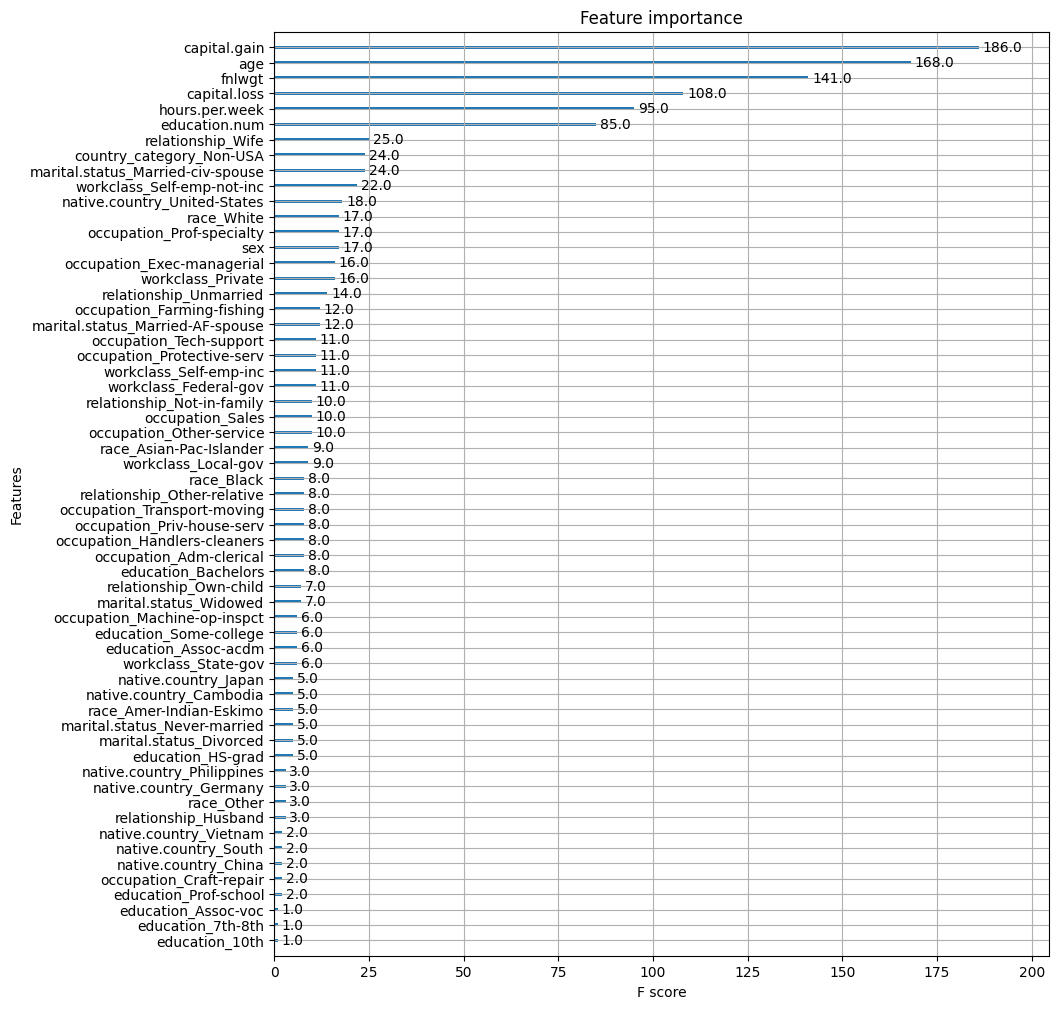

In [21]:
# Step 2: Apply one-hot encoding
case00_train = pd.get_dummies(encoded_train_cleaned, dtype=int)
case00_test = pd.get_dummies(encoded_test_cleaned, dtype=int).reindex(columns=case00_train.columns, fill_value=0)

case13_xgb = run_xgb(*split_data_label(case00_train, case00_test))
feature_13 = check_feature_importance(case13_xgb)

In [23]:
feature_case13_xgb, features = evaluate_accuracy_feature_selection(*split_data_label(case00_train, case00_test), "xgb", case13_xgb)

Initial Accuracy with all features: 0.8754807054767272, Features remaining: 106
Accuracy after removing 1 features: 0.8754807054767272, Features remaining: 105
Accuracy after removing 2 features: 0.8754807054767272, Features remaining: 104
Accuracy after removing 3 features: 0.8754807054767272, Features remaining: 103
Accuracy after removing 4 features: 0.8754807054767272, Features remaining: 102
Accuracy after removing 5 features: 0.8754807054767272, Features remaining: 101
Accuracy after removing 6 features: 0.8754807054767272, Features remaining: 100
Accuracy after removing 7 features: 0.8754807054767272, Features remaining: 99
Accuracy after removing 8 features: 0.8754807054767272, Features remaining: 98
Accuracy after removing 9 features: 0.8754807054767272, Features remaining: 97
Accuracy after removing 10 features: 0.8754807054767272, Features remaining: 96
Accuracy after removing 11 features: 0.8754807054767272, Features remaining: 95
Accuracy after removing 12 features: 0.8754

Maximum Accuracy: 0.8765, Number of Features: 55


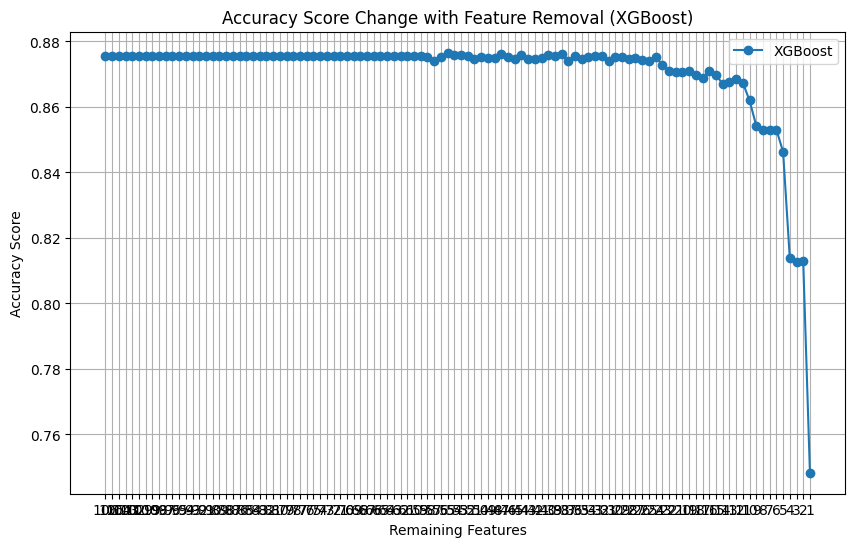

In [25]:
plot_accuracy_change(feature_case13_xgb, features, 'XGBoost')

In [26]:
def run_xgb(X_train, y_train, X_test, y_test):
    xgb_param_grid = {
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [2, 3, 4],
    'n_estimators': [150, 200, 250]
    }

    #xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)
    xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='accuracy')
    xgb_grid_search.fit(X_train, y_train)

    print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
    print(f"Best accuracy for XGBoost: {xgb_grid_search.best_score_}")

    xgb_probs = xgb_grid_search.predict_proba(X_test)

    final_predictions = np.argmax(xgb_probs, axis=1)

    accuracy = accuracy_score(y_test, final_predictions)
    print(f"Soft Voting Accuracy: {accuracy}")

    return xgb_grid_search.best_estimator_

Best parameters for XGBoost: {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8802226220940221
Soft Voting Accuracy: 0.8748176634398621
Total number of features (before filtering): 106
Total number of features (after filtering): 62


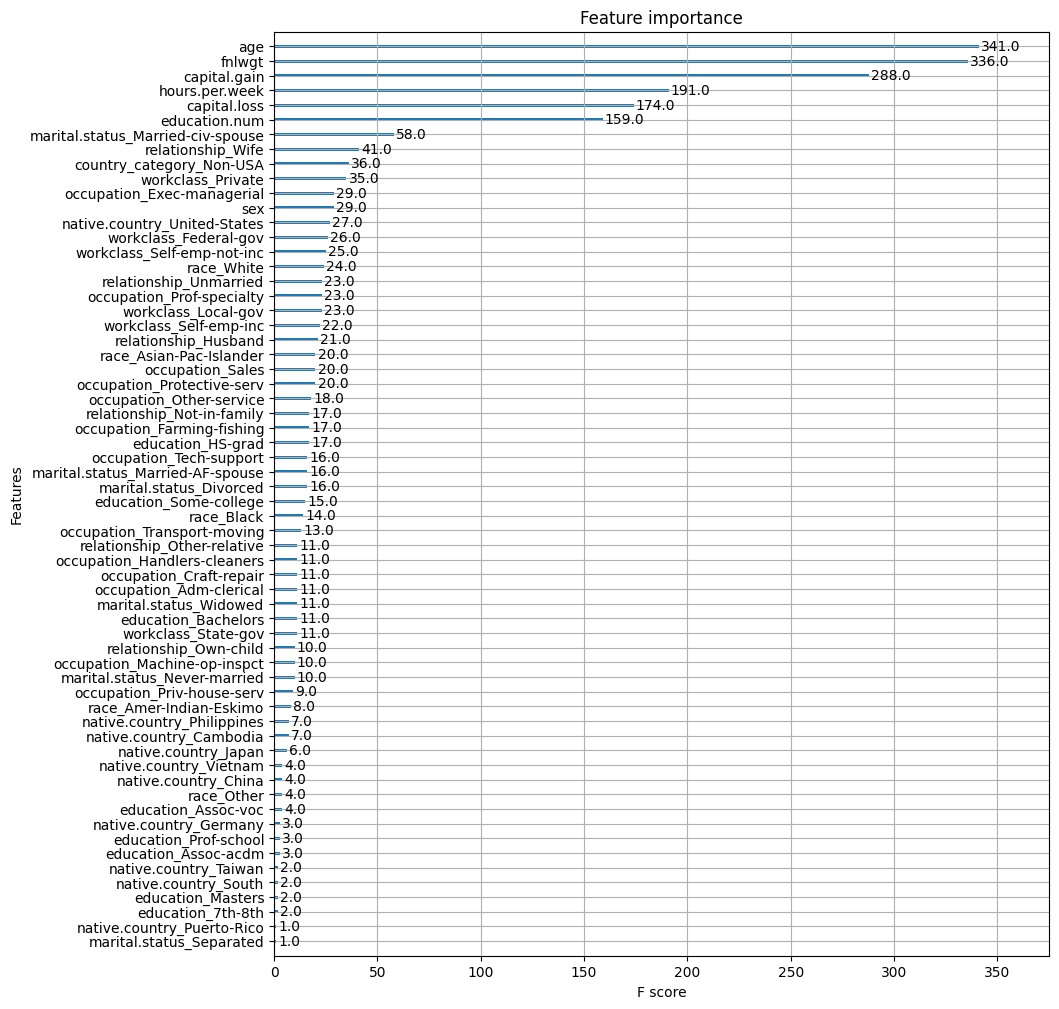

In [27]:
case13_xgb = run_xgb(*split_data_label(case00_train, case00_test))
feature_13 = check_feature_importance(case13_xgb)

In [28]:
feature_case13_xgb, features = evaluate_accuracy_feature_selection(*split_data_label(case00_train, case00_test), "xgb", case13_xgb)

Initial Accuracy with all features: 0.8748176634398621, Features remaining: 106
Accuracy after removing 1 features: 0.8748176634398621, Features remaining: 105
Accuracy after removing 2 features: 0.8748176634398621, Features remaining: 104
Accuracy after removing 3 features: 0.8748176634398621, Features remaining: 103
Accuracy after removing 4 features: 0.8748176634398621, Features remaining: 102
Accuracy after removing 5 features: 0.8748176634398621, Features remaining: 101
Accuracy after removing 6 features: 0.8748176634398621, Features remaining: 100
Accuracy after removing 7 features: 0.8748176634398621, Features remaining: 99
Accuracy after removing 8 features: 0.8748176634398621, Features remaining: 98
Accuracy after removing 9 features: 0.8748176634398621, Features remaining: 97
Accuracy after removing 10 features: 0.8748176634398621, Features remaining: 96
Accuracy after removing 11 features: 0.8748176634398621, Features remaining: 95
Accuracy after removing 12 features: 0.8748

Maximum Accuracy: 0.8767, Number of Features: 50


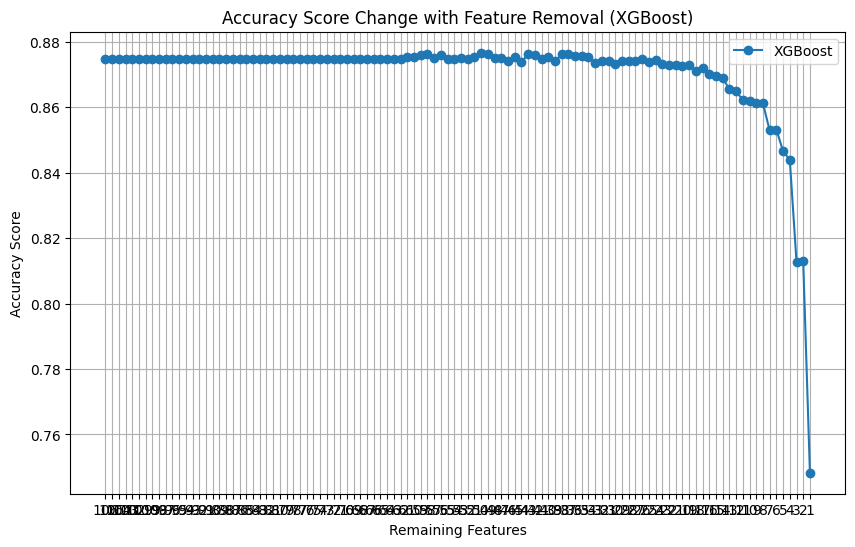

In [29]:
plot_accuracy_change(feature_case13_xgb, features, 'XGBoost')

In [30]:
def run_xgb(X_train, y_train, X_test, y_test):
    xgb_param_grid = {
    'learning_rate': [0.15, 0.17, 0.19, 0.2],
    'max_depth': [3, 4],
    'n_estimators': [200]
    }

    #xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)
    xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='accuracy')
    xgb_grid_search.fit(X_train, y_train)

    print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
    print(f"Best accuracy for XGBoost: {xgb_grid_search.best_score_}")

    xgb_probs = xgb_grid_search.predict_proba(X_test)

    final_predictions = np.argmax(xgb_probs, axis=1)

    accuracy = accuracy_score(y_test, final_predictions)
    print(f"Soft Voting Accuracy: {accuracy}")

    return xgb_grid_search.best_estimator_

Best parameters for XGBoost: {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8802226220940221
Soft Voting Accuracy: 0.8748176634398621
Total number of features (before filtering): 106
Total number of features (after filtering): 62


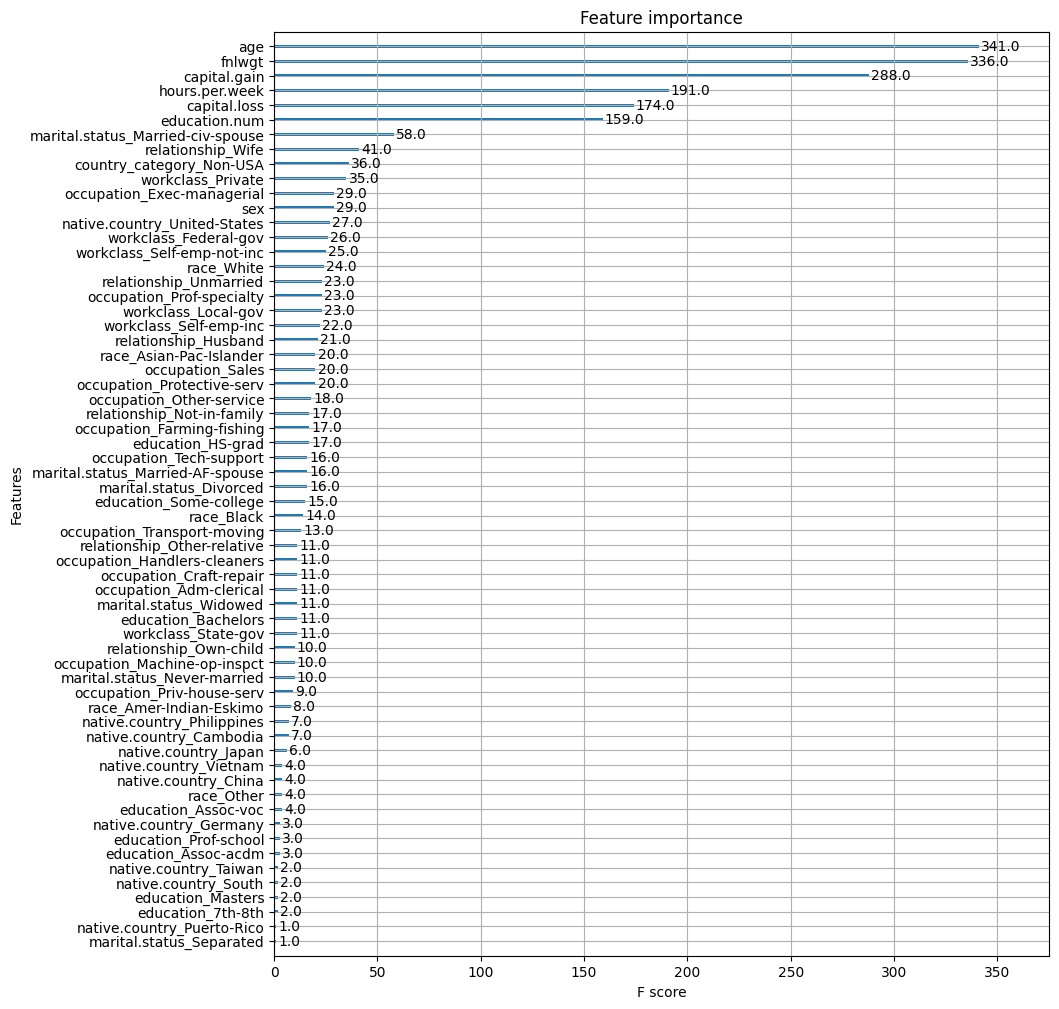

In [31]:
case13_xgb = run_xgb(*split_data_label(case00_train, case00_test))
feature_13 = check_feature_importance(case13_xgb)

In [32]:
feature_case13_xgb, features = evaluate_accuracy_feature_selection(*split_data_label(case00_train, case00_test), "xgb", case13_xgb)

Initial Accuracy with all features: 0.8748176634398621, Features remaining: 106
Accuracy after removing 1 features: 0.8748176634398621, Features remaining: 105
Accuracy after removing 2 features: 0.8748176634398621, Features remaining: 104
Accuracy after removing 3 features: 0.8748176634398621, Features remaining: 103
Accuracy after removing 4 features: 0.8748176634398621, Features remaining: 102
Accuracy after removing 5 features: 0.8748176634398621, Features remaining: 101
Accuracy after removing 6 features: 0.8748176634398621, Features remaining: 100
Accuracy after removing 7 features: 0.8748176634398621, Features remaining: 99
Accuracy after removing 8 features: 0.8748176634398621, Features remaining: 98
Accuracy after removing 9 features: 0.8748176634398621, Features remaining: 97
Accuracy after removing 10 features: 0.8748176634398621, Features remaining: 96
Accuracy after removing 11 features: 0.8748176634398621, Features remaining: 95
Accuracy after removing 12 features: 0.8748

Maximum Accuracy: 0.8767, Number of Features: 50


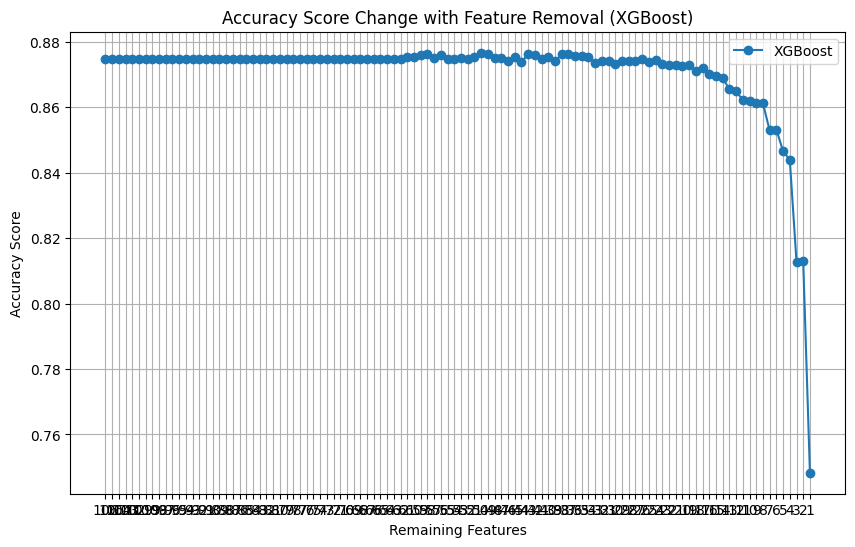

In [33]:
plot_accuracy_change(feature_case13_xgb, features, 'XGBoost')

### 오버샘플링-국가

미국과 미국이 아닌 국가의 수를 비교했을 때

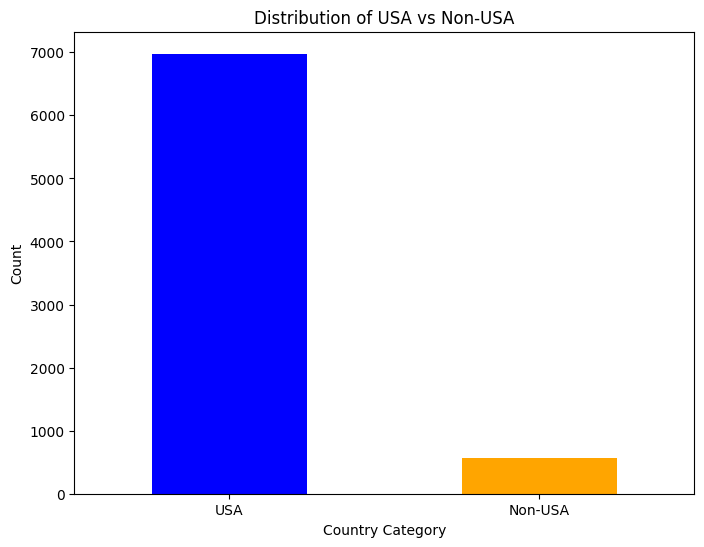

In [ ]:
# Apply the function to the dataframe
_cleaned, _ = categorize_by_native_country_with_conditions(encoded_train)

# Visualize the distribution of the 'country_category'
country_distribution = encoded_train_cleaned['country_category'].value_counts()

import matplotlib.pyplot as plt

# Plotting the distribution of 'country_category'
plt.figure(figsize=(8, 6))
country_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of USA vs Non-USA')
plt.xlabel('Country Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

그래도 여전히 미국의 비율이 압도적임.

native.country 컬럼을 삭제하지 않고 실행했을 때 성능이 좋았던 걸 보면 국가 값이 두번 들어간것인데, 이를 통해 미국이 아닌 국가의 영향력을 키워보면 성능이 좋게 나올 수도 있겠다 생각하였음

 --> 오버샘플링을 통해 비율을 맞춰보자

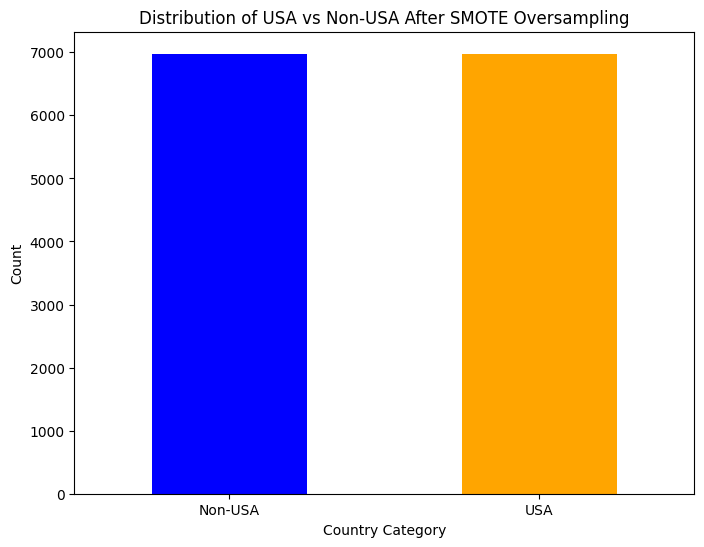

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임을 encoded_train_cleaned로 가정하고 있음
# 필요한 경우 encoded_train_cleaned를 코랩 환경에 로드

# 문자열 열을 수치형으로 변환 (원-핫 인코딩)
X_encoded = pd.get_dummies(encoded_train_cleaned.drop(columns=['country_category']), dtype=int)
y = encoded_train_cleaned['country_category']

# SMOTE를 사용하여 'Non-USA' 카테고리를 오버샘플링
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 오버샘플링 후의 분포 시각화
resampled_distribution = y_resampled.value_counts()

plt.figure(figsize=(8, 6))
resampled_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of USA vs Non-USA After SMOTE Oversampling')
plt.xlabel('Country Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# 오버샘플링된 데이터프레임 생성
encoded_train_cleaned_resampled = pd.concat([X_resampled, y_resampled], axis=1)


In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Step 1: Apply the corrected function to categorize by native country with additional conditions
encoded_train_cleaned, _ = categorize_by_native_country_with_conditions(encoded_train)
encoded_test_cleaned, _ = categorize_by_native_country_with_conditions(encoded_test)

# Step 2: Apply one-hot encoding to the cleaned train and test data
case000_train = pd.get_dummies(encoded_train_cleaned, dtype=int)
case000_test = pd.get_dummies(encoded_test_cleaned, dtype=int).reindex(columns=case000_train.columns, fill_value=0)

# Step 3: Separate features and labels for SMOTE
# income이 타겟 레이블이므로 country_category가 아닌 income을 사용합니다.
X_train = case000_train.drop(columns=['income'])
y_train = case000_train['income']

# Step 4: Apply SMOTE for oversampling
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Combine resampled features and labels
encoded_train_cleaned_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

# Step 6: Run XGBoost model with split data
run_xgb(*split_data_label(encoded_train_cleaned_resampled, case000_test))


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8879265099073722
Soft Voting Accuracy: 0.8560379752015387


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

오버샘플링 결과, train 값에 대한 성능은 좋아졌으나, test 값에 대한 성능은 많이 떨어진것을 확인할 수 있었음.

--> 오버샘플링은 제외하자

In [ ]:
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
print(f"Best accuracy for XGBoost: {xgb_grid_search.best_score_}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:03:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:03:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:03:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:03:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:03:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8688509965845951


In [ ]:
cat_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200]
}

cat = CatBoostClassifier(verbose=False, random_state=42)
cat_grid_search = GridSearchCV(estimator=cat, param_grid=cat_param_grid, cv=5, scoring='accuracy')
cat_grid_search.fit(X_train, y_train)

print(f"Best parameters for CatBoost: {cat_grid_search.best_params_}")
print(f"Best accuracy for CatBoost: {cat_grid_search.best_score_}")

Best parameters for CatBoost: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best accuracy for CatBoost: 0.8655360498371399


In [ ]:
case13_xgb = run_xgb(*split_data_label(encoded_train_cleaned_resampled, case000_test))

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8879265099073722
Soft Voting Accuracy: 0.8560379752015387


### 인사이트 도출


여기부터는 인사이트 도출 파트-현직

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best accuracy for XGBoost: 0.8688509965845951
Soft Voting Accuracy: 0.873838850922781
Total number of features (before filtering): 103
Total number of features (after filtering): 58


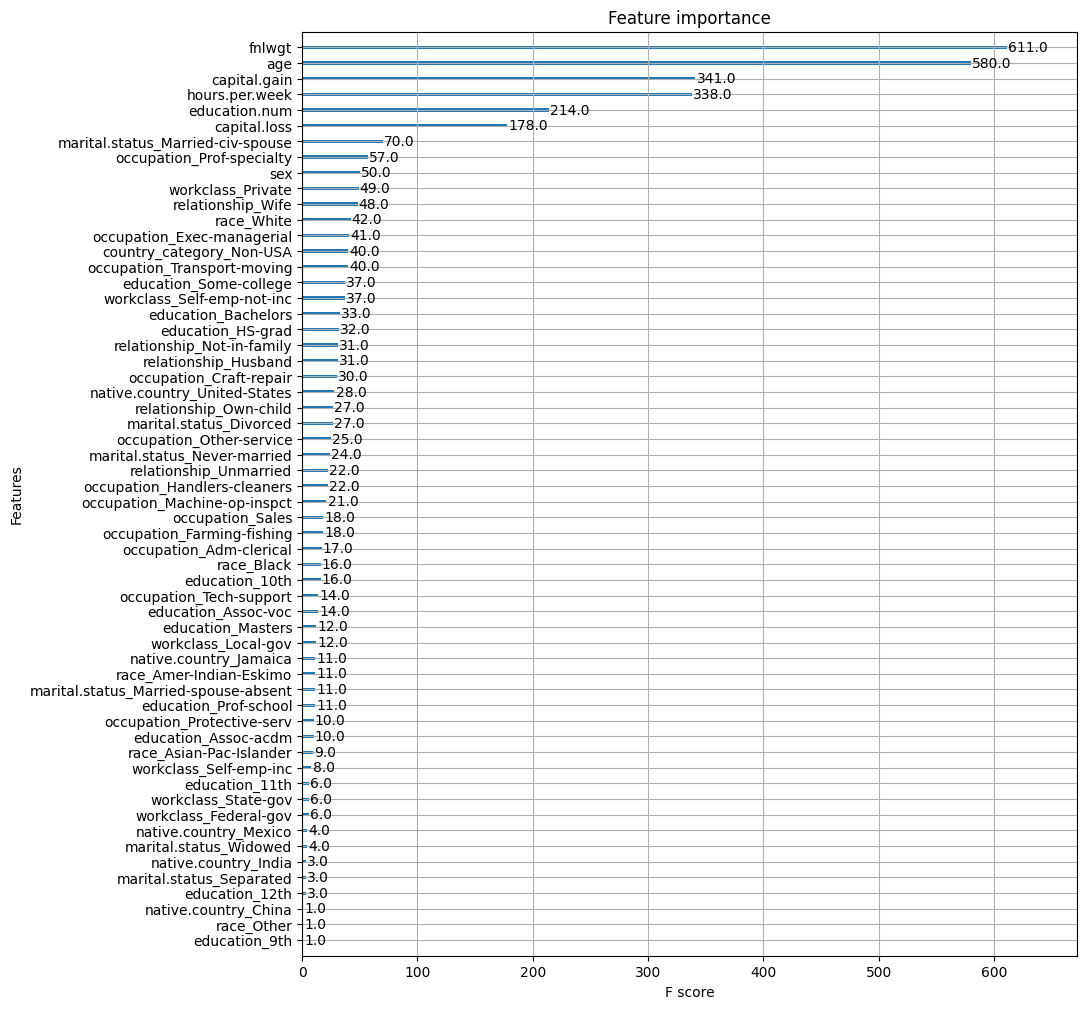

In [ ]:
# Step 2: Apply one-hot encoding
case00_train = pd.get_dummies(encoded_train_cleaned, dtype=int)
case00_test = pd.get_dummies(encoded_test_cleaned, dtype=int).reindex(columns=case00_train.columns, fill_value=0)

case13_xgb = run_xgb(*split_data_label(case00_train, case00_test))
feature_13 = check_feature_importance(case13_xgb)

In [ ]:
# feature_13의 index에 해당하는 컬럼 이름 추출
selected_features = feature_13.index.tolist()

# case00_train에서 해당 컬럼들만 추출하여 새로운 데이터프레임 생성
case00_train_filtered = case00_train[selected_features]

case00_train_filtered


,native.country_Mexico,native.country_Jamaica,education_12th,native.country_China,education_11th,race_Asian-Pac-Islander,native.country_India,marital.status_Divorced,race_Amer-Indian-Eskimo,occupation_Transport-moving,...,capital.loss,country_category_Non-USA,occupation_Other-service,relationship_Own-child,occupation_Exec-managerial,occupation_Farming-fishing,capital.gain,education.num,native.country_United-States,marital.status_Married-civ-spouse
0,0,0,0,0,0,1,0,1,0,0,...,2080,1,0,0,0,0,0,12,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,9,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,13,1,0
3,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,15,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,13,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7536,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,10,1,0
7537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9,1,1
7538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,1,1
7539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,10,1,0


In [ ]:
# case00_train에서 해당 인덱스 컬럼들만 추출하여 상관관계 계산

correlation_matrix = case00_train_filtered.corr()

# 결과 출력
correlation_matrix


,native.country_Mexico,native.country_Jamaica,education_12th,native.country_China,education_11th,race_Asian-Pac-Islander,native.country_India,marital.status_Divorced,race_Amer-Indian-Eskimo,occupation_Transport-moving,...,capital.loss,country_category_Non-USA,occupation_Other-service,relationship_Own-child,occupation_Exec-managerial,occupation_Farming-fishing,capital.gain,education.num,native.country_United-States,marital.status_Married-civ-spouse
native.country_Mexico,1.000000,-0.006206,0.037082,-0.008465,0.007014,-0.025179,-0.008300,-0.037422,0.011864,-0.008879,...,-0.022206,0.473967,0.044589,-0.027669,-0.047081,0.034164,-0.019976,-0.206988,-0.468168,0.009180
native.country_Jamaica,-0.006206,1.000000,-0.005271,-0.002537,0.024404,-0.007546,-0.002487,-0.016999,-0.004550,-0.010207,...,-0.009227,0.139976,0.014992,-0.009146,0.010903,-0.008198,-0.006314,-0.011794,-0.140305,0.002469
education_12th,0.037082,-0.005271,1.000000,-0.007189,-0.023823,-0.008414,-0.007049,-0.012671,-0.002340,0.039857,...,-0.016537,0.023853,0.028997,0.070863,-0.040567,0.006775,-0.016898,-0.102648,-0.021241,-0.042635
native.country_China,-0.008465,-0.002537,-0.007189,1.000000,-0.011465,0.309523,-0.003392,-0.016552,-0.006205,-0.013921,...,0.009740,0.198279,0.016263,-0.011560,0.011019,-0.011181,-0.006359,0.025041,-0.191356,0.012431
education_11th,0.007014,0.024404,-0.023823,-0.011465,1.000000,-0.021624,0.013330,-0.012653,0.013282,0.035795,...,-0.015967,0.011699,0.085715,0.099073,-0.060426,-0.006258,-0.021504,-0.240958,-0.005465,-0.051089
race_Asian-Pac-Islander,-0.025179,-0.007546,-0.008414,0.309523,-0.021624,1.000000,0.261681,-0.032330,-0.018458,-0.020499,...,0.004780,0.413475,0.020373,0.007085,0.002347,-0.011973,0.026738,0.059601,-0.380091,-0.013455
native.country_India,-0.008300,-0.002487,-0.007049,-0.003392,0.013330,0.261681,1.000000,-0.022732,-0.006084,-0.013650,...,-0.003210,0.194078,-0.012485,-0.004307,-0.001620,-0.010963,0.057278,0.051251,-0.187627,0.024098
marital.status_Divorced,-0.037422,-0.016999,-0.012671,-0.016552,-0.012653,-0.032330,-0.022732,1.000000,0.006853,-0.016973,...,-0.011798,-0.042614,0.010846,-0.074166,0.010147,-0.032552,-0.014475,-0.001861,0.054721,-0.372232
race_Amer-Indian-Eskimo,0.011864,-0.004550,-0.002340,-0.006205,0.013282,-0.018458,-0.006084,0.006853,1.000000,0.009059,...,-0.011172,0.003828,0.016985,-0.004139,-0.010384,-0.006198,0.000079,-0.042239,0.000748,-0.023242
occupation_Transport-moving,-0.008879,-0.010207,0.039857,-0.013921,0.035795,-0.020499,-0.013650,-0.016973,0.009059,1.000000,...,-0.018900,-0.029053,-0.081875,-0.037760,-0.091255,-0.044991,-0.023291,-0.123701,0.026401,0.075185


In [ ]:
# 상관계수가 0.4 이상이고 1.0보다 작은 값들만 추출
high_corr = correlation_matrix[(correlation_matrix > 0.3) & (correlation_matrix < 1.0)]

# NaN이 아닌 값들만 추출하여 새로운 데이터프레임 생성
high_corr_filtered = high_corr.stack().reset_index()
high_corr_filtered.columns = ['Feature 1', 'Feature 2', 'Correlation Value']

# 결과 출력
high_corr_filtered


,Feature 1,Feature 2,Correlation Value
0,native.country_Mexico,country_category_Non-USA,0.473967
1,native.country_China,race_Asian-Pac-Islander,0.309523
2,race_Asian-Pac-Islander,native.country_China,0.309523
3,race_Asian-Pac-Islander,country_category_Non-USA,0.413475
4,marital.status_Divorced,relationship_Unmarried,0.325642
5,marital.status_Never-married,relationship_Not-in-family,0.336836
6,marital.status_Never-married,relationship_Own-child,0.489573
7,relationship_Unmarried,marital.status_Divorced,0.325642
8,education_Bachelors,education.num,0.515787
9,education_Masters,education.num,0.354964


Number of Clusters: 2, Silhouette Score: 0.2518
Number of Clusters: 3, Silhouette Score: 0.2834
Number of Clusters: 4, Silhouette Score: 0.3206
Number of Clusters: 5, Silhouette Score: 0.3390
Number of Clusters: 6, Silhouette Score: 0.3487
Number of Clusters: 7, Silhouette Score: 0.3508
Number of Clusters: 8, Silhouette Score: 0.3713
Number of Clusters: 9, Silhouette Score: 0.3931
Number of Clusters: 10, Silhouette Score: 0.3824


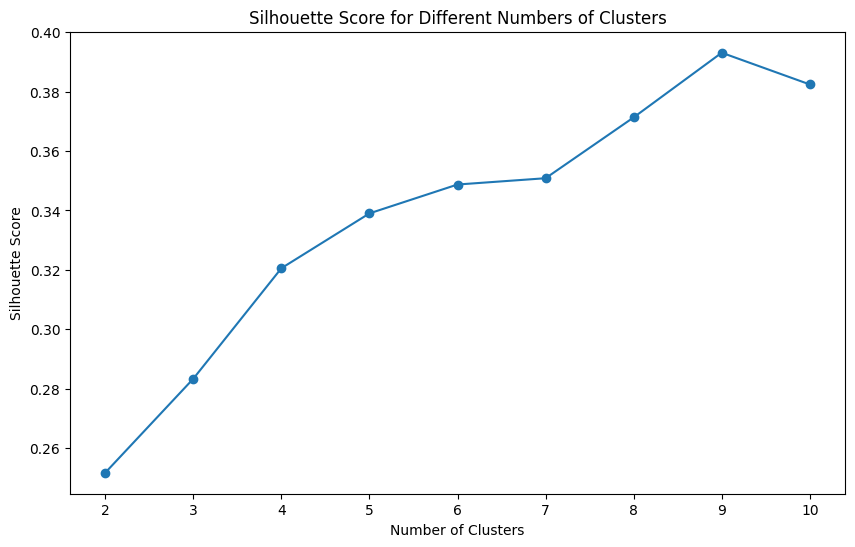

Optimal number of clusters based on silhouette score: 9

Cluster Centers:
   race_Asian-Pac-Islander  education_Bachelors  relationship_Husband  \
0             1.641048e-15         2.033683e-01          8.960915e-01   
1            -3.781697e-16         2.209217e-01          5.995204e-15   
2             2.428613e-17         1.086957e-01         -7.771561e-16   
3             9.230769e-01         4.230769e-01          4.615385e-01   
4             1.000000e+00         2.800000e-01          3.650000e-01   
5             3.642919e-16         1.266234e-01         -7.771561e-16   
6             4.544976e-16         1.145686e-01         -7.771561e-16   
7            -2.081668e-17         2.614379e-02          4.444444e-01   
8            -9.714451e-17         6.661338e-16          5.654596e-01   

   education.num  marital.status_Married-civ-spouse  native.country_Mexico  \
0      10.143947                       9.971401e-01          -1.419004e-15   
1      10.149232                       

<ipython-input-157-21fe452e0086>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_corr_df['Cluster'] = cluster_labels


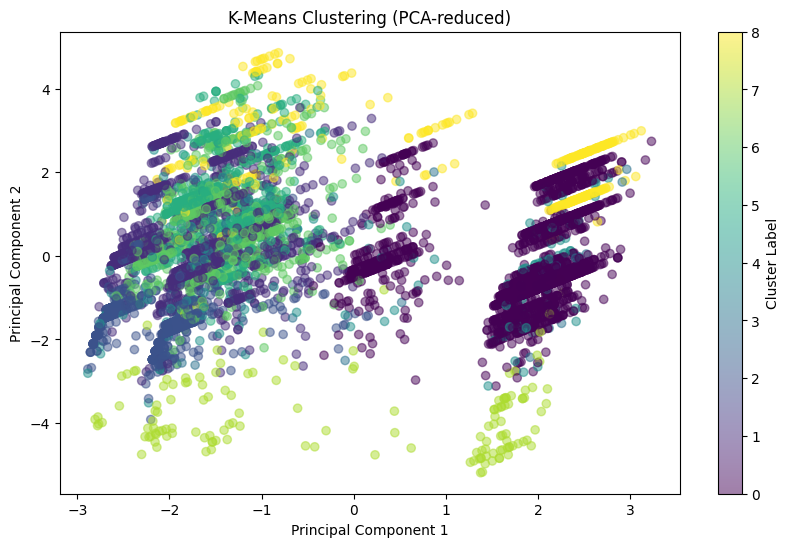


Cluster Counts:
Cluster
0    3147
1    1367
2     966
6     707
5     616
8     359
4     200
7     153
3      26
Name: count, dtype: int64

Cluster Summary (Mean Values):
         race_Asian-Pac-Islander  education_Bachelors  relationship_Husband  \
Cluster                                                                       
0                       0.000000             0.203368              0.896092   
1                       0.000000             0.220922              0.000000   
2                       0.000000             0.108696              0.000000   
3                       0.923077             0.423077              0.461538   
4                       1.000000             0.280000              0.365000   
5                       0.000000             0.126623              0.000000   
6                       0.000000             0.114569              0.000000   
7                       0.000000             0.026144              0.444444   
8                       0.000000     

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming 'high_corr_filtered' and 'case00_train' are already defined as per the previous context

# Extract features with high correlation
high_corr_features = set(high_corr_filtered['Feature 1']).union(set(high_corr_filtered['Feature 2']))
high_corr_df = case00_train[list(high_corr_features)]

# Step 2: Data scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(high_corr_df)

# Step 3: Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
cluster_range = range(2, 11)  # Testing cluster sizes from 2 to 10

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Number of Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}')

# Plot silhouette scores for visualization
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Step 4: Select the optimal number of clusters (the one with the highest silhouette score)
optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]

print(f'Optimal number of clusters based on silhouette score: {optimal_clusters}')

# Step 5: K-Means clustering using the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataframe
high_corr_df['Cluster'] = cluster_labels

# Step 6: Cluster centers and characteristics analysis
cluster_centers = kmeans.cluster_centers_
cluster_centers_df = pd.DataFrame(scaler.inverse_transform(cluster_centers), columns=high_corr_df.columns[:-1])

print("\nCluster Centers:")
print(cluster_centers_df)

# Step 7: Visualize clustering results using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Step 8: Count the number of data points in each cluster
cluster_counts = high_corr_df['Cluster'].value_counts()
print("\nCluster Counts:")
print(cluster_counts)

# Step 9: Analyze the main characteristics of each cluster
cluster_summary = high_corr_df.groupby('Cluster').mean()
print("\nCluster Summary (Mean Values):")
print(cluster_summary)



In [ ]:
# Step 8: Count the number of data points in each cluster
cluster_counts = high_corr_df['Cluster'].value_counts()
print("\nCluster Counts:")
display(cluster_counts)

# Step 9: Analyze the main characteristics of each cluster
cluster_summary = high_corr_df.groupby('Cluster').mean()
print("\nCluster Summary (Mean Values):")
display(cluster_summary)



Cluster Counts:


,count
Cluster,
0,3147
1,1367
2,966
6,707
5,616
8,359
4,200
7,153
3,26



Cluster Summary (Mean Values):


,race_Asian-Pac-Islander,education_Bachelors,relationship_Husband,education.num,marital.status_Married-civ-spouse,native.country_Mexico,education_Masters,marital.status_Never-married,occupation_Prof-specialty,sex,country_category_Non-USA,relationship_Own-child,age,relationship_Unmarried,marital.status_Divorced,native.country_China,relationship_Not-in-family
Cluster,,,,,,,,,,,,,,,,,
0,0.000000,0.203368,0.896092,10.143947,0.997140,0.0,0.000000,0.000000,0.126470,0.900858,0.027328,0.000000,43.052749,0.000000,0.000000,0.0,0.000318
1,0.000000,0.220922,0.000000,10.149232,0.001463,0.0,0.000000,0.823702,0.142648,0.558888,0.058522,0.000000,34.334309,0.000000,0.000000,0.0,0.916606
2,0.000000,0.108696,0.000000,9.451346,0.016563,0.0,0.000000,0.948240,0.067288,0.579710,0.040373,1.000000,24.249482,0.000000,0.002070,0.0,0.000000
3,0.923077,0.423077,0.461538,11.192308,0.576923,0.0,0.153846,0.192308,0.230769,0.692308,0.961538,0.076923,42.961538,0.038462,0.038462,1.0,0.307692
4,1.000000,0.280000,0.365000,10.965000,0.415000,0.0,0.075000,0.415000,0.195000,0.700000,0.660000,0.170000,38.600000,0.125000,0.075000,0.0,0.255000
5,0.000000,0.126623,0.000000,9.917208,0.000000,0.0,0.000000,0.000000,0.094156,0.516234,0.024351,0.125000,43.269481,0.000000,1.000000,0.0,0.831169
6,0.000000,0.114569,0.000000,9.567185,0.000000,0.0,0.000000,0.256011,0.111740,0.264498,0.053748,0.000000,40.980198,1.000000,0.468175,0.0,0.000000
7,0.000000,0.026144,0.444444,6.490196,0.503268,1.0,0.019608,0.320261,0.026144,0.777778,0.941176,0.078431,33.392157,0.143791,0.045752,0.0,0.183007
8,0.000000,0.000000,0.565460,14.000000,0.623955,0.0,1.000000,0.225627,0.504178,0.710306,0.013928,0.036212,43.930362,0.069638,0.116992,0.0,0.272981


In [ ]:


# 예시: 'income' 컬럼이 case12_train에 존재한다고 가정하고 이를 high_corr_df에 추가
high_corr_df['income'] = case00_train['income']

# Step 1: 각 클러스터별 income 비율 계산
income_distribution_per_cluster = high_corr_df.groupby('Cluster')['income'].value_counts(normalize=True).unstack()

# Step 2: 결과 출력
print("Income Distribution per Cluster:")
print(income_distribution_per_cluster)

Income Distribution per Cluster:
income          0         1
Cluster                    
0        0.567525  0.432475
1        0.918069  0.081931
2        0.989648  0.010352
3        0.692308  0.307692
4        0.725000  0.275000
5        0.884740  0.115260
6        0.929279  0.070721
7        0.941176  0.058824
8        0.381616  0.618384


<ipython-input-159-a064fca0e6b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_corr_df['income'] = case00_train['income']


클러스터 0 / 클러스터 1,2,5,6,7 / 클러스터 3,4 / 클러스터 8

In [ ]:
#클러스터 0만의 특징 찾기

# Step 1: 각 클러스터의 평균 값 계산
cluster_summary = high_corr_df.groupby('Cluster').mean()

# Step 2: 클러스터 1과 다른 클러스터의 평균 값 차이 계산
# 다른 클러스터들의 평균값
other_clusters_mean = cluster_summary[cluster_summary.index != 0].mean()

# 클러스터 1과 다른 클러스터들의 평균 차이
diff_from_other_clusters = cluster_summary.loc[0] - other_clusters_mean

# Step 3: 클러스터 1이 다른 클러스터와 가장 큰 차이를 보이는 컬럼 정렬
diff_from_other_clusters = diff_from_other_clusters.sort_values(ascending=False)

# 결과 출력: 클러스터 0의 특징을 나타내는 상위 10개의 컬럼
print("Top 10 Features That Differentiate Cluster 0 from Others:")
print(diff_from_other_clusters.head(10))

Top 10 Features That Differentiate Cluster 0 from Others:
age                                  5.338058
marital.status_Married-civ-spouse    0.729994
relationship_Husband                 0.666536
sex                                  0.300893
income                               0.240205
education_Bachelors                  0.040865
occupation_Prof-specialty           -0.045021
education.num                       -0.072613
native.country_Mexico               -0.125000
native.country_China                -0.125000
dtype: float64


In [ ]:
#클러스터 2만의 특징 찾기

# Step 1: 각 클러스터의 평균 값 계산
cluster_summary = high_corr_df.groupby('Cluster').mean()

# Step 2: 클러스터 1과 다른 클러스터의 평균 값 차이 계산
# 다른 클러스터들의 평균값
other_clusters_mean = cluster_summary[cluster_summary.index != 2].mean()

# 클러스터 1과 다른 클러스터들의 평균 차이
diff_from_other_clusters = cluster_summary.loc[2] - other_clusters_mean

# Step 3: 클러스터 1이 다른 클러스터와 가장 큰 차이를 보이는 컬럼 정렬
diff_from_other_clusters = diff_from_other_clusters.sort_values(ascending=False)

# 결과 출력: 클러스터 0의 특징을 나타내는 상위 10개의 컬럼
print("Top 10 Features That Differentiate Cluster 2 from Others:")
print(diff_from_other_clusters.head(10))

Top 10 Features That Differentiate Cluster 2 from Others:
relationship_Own-child          0.939179
marital.status_Never-married    0.669127
sex                            -0.060399
education_Bachelors            -0.065642
occupation_Prof-specialty      -0.111600
native.country_China           -0.125000
native.country_Mexico          -0.125000
education_Masters              -0.156057
relationship_Unmarried         -0.172111
marital.status_Divorced        -0.215977
dtype: float64


In [ ]:
#클러스터 4만의 특징 찾기

# Step 1: 각 클러스터의 평균 값 계산
cluster_summary = high_corr_df.groupby('Cluster').mean()

# Step 2: 클러스터 1과 다른 클러스터의 평균 값 차이 계산
# 다른 클러스터들의 평균값
other_clusters_mean = cluster_summary[cluster_summary.index != 4].mean()

# 클러스터 1과 다른 클러스터들의 평균 차이
diff_from_other_clusters = cluster_summary.loc[4] - other_clusters_mean

# Step 3: 클러스터 1이 다른 클러스터와 가장 큰 차이를 보이는 컬럼 정렬
diff_from_other_clusters = diff_from_other_clusters.sort_values(ascending=False)

# 결과 출력: 클러스터 0의 특징을 나타내는 상위 10개의 컬럼
print("Top 10 Features That Differentiate Cluster 4 from Others:")
print(diff_from_other_clusters.head(10))

Top 10 Features That Differentiate Cluster 4 from Others:
race_Asian-Pac-Islander              0.884615
education.num                        0.851072
country_category_Non-USA             0.394880
age                                  0.328716
education_Bachelors                  0.127075
marital.status_Married-civ-spouse    0.075086
sex                                  0.074928
marital.status_Never-married         0.069231
relationship_Husband                 0.069058
income                               0.063045
dtype: float64


In [ ]:
#클러스터 8만의 특징 찾기

# Step 1: 각 클러스터의 평균 값 계산
cluster_summary = high_corr_df.groupby('Cluster').mean()

# Step 2: 클러스터 1과 다른 클러스터의 평균 값 차이 계산
# 다른 클러스터들의 평균값
other_clusters_mean = cluster_summary[cluster_summary.index != 8].mean()

# 클러스터 1과 다른 클러스터들의 평균 차이
diff_from_other_clusters = cluster_summary.loc[8] - other_clusters_mean

# Step 3: 클러스터 1이 다른 클러스터와 가장 큰 차이를 보이는 컬럼 정렬
diff_from_other_clusters = diff_from_other_clusters.sort_values(ascending=False)

# 결과 출력: 클러스터 8의 특징을 나타내는 상위 10개의 컬럼
print("Top 10 Features That Differentiate Cluster 8 from Others:")
print(diff_from_other_clusters.head(10))



Top 10 Features That Differentiate Cluster 8 from Others:
age                                  6.325373
education.num                        4.265447
education_Masters                    0.968943
income                               0.449352
occupation_Prof-specialty            0.379901
marital.status_Married-civ-spouse    0.310161
relationship_Husband                 0.294575
sex                                  0.086522
relationship_Not-in-family          -0.038743
marital.status_Divorced             -0.086691
dtype: float64


결국, 나이, 결혼유무, 관계, 학력수준, 인종이 다른 어떤 요소들보다 수입 결정에 중요했다.

---



In [ ]:
# 필요한 컬럼 추출
selected_columns = ['age', 'education.num'] + \
                   [col for col in cluster_summary.columns if col.startswith('marital.status')] + \
                   [col for col in cluster_summary.columns if col.startswith('relationship')] + \
                   [col for col in cluster_summary.columns if col.startswith('race')]

# cluster_summary에서 선택한 컬럼만 가져오기
filtered_summary = cluster_summary[selected_columns]

filtered_summary

# 클러스터 2하고 0 & 5하고 비교했을 때 보면,

,age,education.num,marital.status_Married-civ-spouse,marital.status_Never-married,marital.status_Divorced,relationship_Husband,relationship_Own-child,relationship_Unmarried,relationship_Not-in-family,race_Asian-Pac-Islander
Cluster,,,,,,,,,,
0,43.052749,10.143947,0.997140,0.000000,0.000000,0.896092,0.000000,0.000000,0.000318,0.000000
1,34.334309,10.149232,0.001463,0.823702,0.000000,0.000000,0.000000,0.000000,0.916606,0.000000
2,24.249482,9.451346,0.016563,0.948240,0.002070,0.000000,1.000000,0.000000,0.000000,0.000000
3,42.961538,11.192308,0.576923,0.192308,0.038462,0.461538,0.076923,0.038462,0.307692,0.923077
4,38.600000,10.965000,0.415000,0.415000,0.075000,0.365000,0.170000,0.125000,0.255000,1.000000
5,43.269481,9.917208,0.000000,0.000000,1.000000,0.000000,0.125000,0.000000,0.831169,0.000000
6,40.980198,9.567185,0.000000,0.256011,0.468175,0.000000,0.000000,1.000000,0.000000,0.000000
7,33.392157,6.490196,0.503268,0.320261,0.045752,0.444444,0.078431,0.143791,0.183007,0.000000
8,43.930362,14.000000,0.623955,0.225627,0.116992,0.565460,0.036212,0.069638,0.272981,0.000000


In [ ]:
# 클러스터 컬럼이 2, ,8인 행만 필터링
filtered_clusters = filtered_summary.loc[filtered_summary.index.isin([2, 8])]

filtered_clusters

,age,education.num,marital.status_Married-civ-spouse,marital.status_Never-married,marital.status_Divorced,relationship_Husband,relationship_Own-child,relationship_Unmarried,relationship_Not-in-family,race_Asian-Pac-Islander
Cluster,,,,,,,,,,
2,24.249482,9.451346,0.016563,0.948240,0.002070,0.00000,1.000000,0.000000,0.000000,0.0
8,43.930362,14.000000,0.623955,0.225627,0.116992,0.56546,0.036212,0.069638,0.272981,0.0
